# CS_BP预处理部分

修改版（改进如下）其中1,4为核心点，已完成；2,3不打算搞了，意义不大。
1：使用反向学习和混沌初始化解决随机初始化种群在整个搜索空间分布不均的问题，整加初始种群的表达能力
2：局部优化的时候随机生成反向的两组，增加局部收敛速度,
3：局部优化修改原始的随机淘汰一部分nest的方式，使用每隔一段周期，计算在在些周期过去之后适应度进化程度百分比最低的nest，因为这些nests很有可能陷入了局部最优。新的位置选择随机两组较优nest之间，保证算法的全局收敛能力。
4:引入adaboost,组合多个CS-BP模型，其中每个CS的nests初始化使用tent初始化，对于tent的初值不再靠实验，而是产生多个足够有差异CS-BP，最后组合优化

In [326]:
import numpy as np
import scipy.special as sc_special
import tensorflow as tf 
from 	tensorflow import keras
import pandas as pd
from tensorflow.keras import optimizers,metrics,layers,Sequential

In [327]:
# 导入数据以及预处理
data = pd.read_csv('GY_AIR.csv',sep=',',header=0,usecols=[1,2,3,4,5,6,7])
X = data.iloc[:400,1:]
Y = data.iloc[:400,0]
TestX = data.iloc[400:,1:]
TestY = data.iloc[400:,0]

inputnum = 6
hiddennum = 10
outputnum = 3
numsum = inputnum*hiddennum+hiddennum+hiddennum*outputnum+outputnum #6*10+10+10*3+3=103
bestfit = []  #保存CS迭代过程中的loss、acc，画图用
bestloss = []
LossArr = []


n_train = X.shape[0]
#弱分类器数量
M = 5


def preprocess(x,y):
    x = tf.cast(x,dtype=tf.float32) #/ X.max().max()
    y = tf.cast(y,dtype=tf.int32)
    y = tf.one_hot(y,depth=3)
    return x,y

In [328]:
#数据预处理

#零均值处理
X.iloc[:,0] -= np.mean(X,axis=0)[0]  
X.iloc[:,1] -= np.mean(X,axis=0)[1]
X.iloc[:,2] -= np.mean(X,axis=0)[2]
X.iloc[:,3] -= np.mean(X,axis=0)[3]  
X.iloc[:,4] -= np.mean(X,axis=0)[4]
X.iloc[:,5] -= np.mean(X,axis=0)[5]
#归一化
X.iloc[:,0] /= np.max(np.abs(X),axis=0)[0]
X.iloc[:,1] /= np.max(np.abs(X),axis=0)[1]
X.iloc[:,2] /= np.max(np.abs(X),axis=0)[2]
X.iloc[:,3] /= np.max(np.abs(X),axis=0)[3]  
X.iloc[:,4] /= np.max(np.abs(X),axis=0)[4]
X.iloc[:,5] /= np.max(np.abs(X),axis=0)[5]
#零均值处理
TestX.iloc[:,0] -= np.mean(TestX,axis=0)[0]  
TestX.iloc[:,1] -= np.mean(TestX,axis=0)[1]
TestX.iloc[:,2] -= np.mean(TestX,axis=0)[2]
TestX.iloc[:,3] -= np.mean(TestX,axis=0)[3]  
TestX.iloc[:,4] -= np.mean(TestX,axis=0)[4]
TestX.iloc[:,5] -= np.mean(TestX,axis=0)[5]
#归一化
TestX.iloc[:,0] /= np.max(np.abs(TestX),axis=0)[0]
TestX.iloc[:,1] /= np.max(np.abs(TestX),axis=0)[1]
TestX.iloc[:,2] /= np.max(np.abs(TestX),axis=0)[2]
TestX.iloc[:,3] /= np.max(np.abs(TestX),axis=0)[3]  
TestX.iloc[:,4] /= np.max(np.abs(TestX),axis=0)[4]
TestX.iloc[:,5] /= np.max(np.abs(TestX),axis=0)[5]
batchsz = 32
db = tf.data.Dataset.from_tensor_slices((X,Y))
db = db.map(preprocess).batch(batchsz)#.shuffle(60000)
ds_val = tf.data.Dataset.from_tensor_slices((TestX,TestY))
ds_val = ds_val.map(preprocess).batch(batchsz)
sample = next(iter(db))
print(sample[0].shape,sample[1].shape)
Y_onehot = tf.one_hot(Y,depth=3)
TestY_onehot = tf.one_hot(TestY,depth=3)
X = tf.cast(X,dtype=tf.float32)# / 203.
TestX = tf.cast(TestX,dtype=tf.float32) #/ 203.

(32, 6) (32, 3)


# CS部分

In [329]:

#n：布谷鸟数  m：布谷鸟的维度
def cuckoo_search(n, m, lower_boundary, upper_boundary, iter_num = 20,pa = 0.25, beta = 1.5, step_size = 0.1,alpha=0.77,xn=0.33):

    num=1
    # get initial nests' locations 
    nests,best_nest,best_fitness,lossness = generate_nests(n, m,alpha,xn) #alpha,xn用于tent初始化阈值和初值设置
    
    # get the best nest and record it
    bestfit.append(best_fitness) #全局变量，保存每代最佳适应度值
    

    print('\r\n BEST_LOSSNESS IS %.2f : \r\n',best_fitness)

    for _ in range(iter_num):
        
        print('\r\n******************************************************第 %d 代开始迭代优化************************************************************\r\n'%num)
        nests = update_nests(lower_boundary, upper_boundary, nests, best_nest, lossness, step_size,best_fitness)
        nests = abandon_nests(nests, lower_boundary, upper_boundary, pa)
        
        print('\r\n*****************************************************第 %d 次迭代，计算适应度********************************************************\r\n'%num)
        fitness,lossness,_ = calc_fitness( nests)
        print('\r\n*********************************************************第 %d 次迭代结束************************************************************\r\n'%num)
        
        min_loss_index = np.argmin(lossness)
        min_loss = lossness[min_loss_index]
        min_loss_fit = fitness[min_loss_index]
        min_nestloss = nests[min_loss_index]
        LossArr.append(min_loss)
            
        if min_loss < best_fitness  : #and  min_loss_fit > best_two_fitness
            best_nest = min_nestloss
            best_fitness = min_loss
            best_acc = min_loss_fit
            print('\r\n******')
            print('\r\n 第 %d 次迭代最优Loss是 %.2f : \r\n'%(num,best_fitness))
            print('\r\n******\r\n')
        num+=1

    return (best_nest, best_fitness,best_acc)

In [330]:
def generate_nests(n, m,alpha,xn):

#随机生成nest
#     lower_boundary = np.array(lower_boundary)
#     upper_boundary = np.array(upper_boundary)
#     nests = np.empty((n, m))

#     for each_nest in range(n):
#         nests[each_nest] = lower_boundary + np.array([np.random.rand() for _ in range(m)]) * (upper_boundary - lower_boundary)

#Tent混沌反向初始化

#混沌初始化
    nests = np.empty((n, m))
    sig_nest = np.empty(m)
    alpha = alpha
    xn = xn
    for i in range(0,n):   #*2 值域为【-1,1】 *6 值域为[-3,3]
        for j in range(0,m):
            if 0<=xn<alpha:
                xn = xn/alpha
                sig_nest[j]=(xn-0.5)*6
            elif alpha <= xn <= 1:
                xn = (1-xn)/(1-alpha)
                sig_nest[j] = (xn-0.5)*6
            nests[i] = sig_nest
            
#反向初始化            
    renests = -1 * nests   #定义：Pi = ai + bi - pi  生成反向nests
    
#拼接两个初始化nests
    nests = np.vstack((nests,renests))  #拼接nests和renests 准备计算适应度选择最优的n个nest
    
#计算适应度
    fitness,lossness,_ = calc_fitness( nests) 
    
#根据loss值排序
    arrIndex = np.argsort(lossness)   #获得排序数组  从小到大
    lossness = lossness[arrIndex]     #将lossness数组按照从小到大排序
    nests = nests[arrIndex]    #将nests也按照相同序列进行排序，保证和lossness对齐
    
#删除多余的n组nest，这里从最底下开始一个个删，因为已经排好序了，所以删除的为效果最差的
    for i in range(n):
        nests = np.delete(nests,-1,0)
        lossness = np.delete(lossness,-1,0)
#现在的nests是按照loss排序的，第一个loss最小

    return nests,nests[0],lossness[0],lossness

In [331]:
def update_nests(lower_boundary, upper_boundary, nests, best_nest, lossness, step_coefficient,bestfitness):

    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    # 莱维飞行生成步长：较长时间的短步长和较短时间的长步长
    #生成的步长的shape也是n*m，保证所有元素得到更新
    #这个步长通过step_size来控制大小
    steps = levy_flight(n, m, 1.5)
    new_nests = nests.copy()

    for each_nest in range(n):
        # coefficient 0.01 is to avoid levy flights becoming too aggresive
        # and (nest[each_nest] - best_nest) 保留了最佳nest，但会导致局部最优
        step_size = step_coefficient * steps[each_nest] # * (nests[each_nest] - best_nest)
        step_direction = np.random.rand(m) #0-1均匀概率分布生成方向
        #新的布谷鸟在原来的基础上加上步长和方向
        new_nests[each_nest] += step_size * step_direction  
        # apply boundary condtions
        new_nests[each_nest][new_nests[each_nest] < lower_boundary] = lower_boundary[new_nests[each_nest] < lower_boundary]
        new_nests[each_nest][new_nests[each_nest] > upper_boundary] = upper_boundary[new_nests[each_nest] > upper_boundary]

    new_fitness,new_losses,new_nests = calc_fitness(new_nests)
    #适应度更好的才更新过去
    
    nests[new_losses < lossness] = new_nests[new_losses < lossness] 
    return nests

In [332]:
def abandon_nests(nests, lower_boundary, upper_boundary, pa):

    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    for each_nest in range(n):  
        #pa概率抛弃，抛弃后重新生成
        if (np.random.rand() < pa):
            #局部随机行走生成步长
            #随机两个种群相差*一个0-1的随机数
            step_size = np.random.rand() * (nests[np.random.randint(0, n)] - nests[np.random.randint(0, n)])
            nests[each_nest] += step_size
            # apply boundary condtions
            nests[each_nest][nests[each_nest] < lower_boundary] = lower_boundary[nests[each_nest] < lower_boundary]
            nests[each_nest][nests[each_nest] > upper_boundary] = upper_boundary[nests[each_nest] > upper_boundary]
    
    return nests

In [333]:
def levy_flight(n, m, beta):

    sigma_u = (sc_special.gamma(1+beta)*np.sin(np.pi*beta/2)/(sc_special.gamma((1+beta)/2)*beta*(2**((beta-1)/2))))**(1/beta)
    sigma_v = 1

    u =  np.random.normal(0, sigma_u, (n, m))
    v = np.random.normal(0, sigma_v, (n, m))

    steps = u/((np.abs(v))**(1/beta))

    return steps

In [334]:
def calc_fitness(nests):
    
    n, m = nests.shape
    fitness = np.empty(n)
    lossness = np.empty(n)
    new_nests = nests
    for Sig_nest in range(n):
        chrom = nests[Sig_nest]
        #分解模型参数
        w1 = chrom[:inputnum*hiddennum]
        w1 = w1.reshape(inputnum,hiddennum)
        b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
        w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
        w2 = w2.reshape(hiddennum,outputnum)
        b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

        WB_l1 = (w1,b1)
        WB_l2 = (w2,b2)
        #创建模型，并赋予参数
        model = keras.Sequential([
            keras.layers.Dense(hiddennum,activation='relu',name='l1'),
            keras.layers.Dense(outputnum,name='l2')
        ])
        model.build(input_shape=[None,inputnum])
        
        #model.summary()
        model.compile(optimizer=optimizers.Adam(lr=0.01),
                    loss='mse',
                    metrics=['accuracy'])
        
        layer1 = model.get_layer('l1')
        layer2 = model.get_layer('l2')
        layer1.set_weights(WB_l1)
        layer2.set_weights(WB_l2)
        
        #训练模型
        #model.fit(db,epochs=1,validation_data=ds_val,validation_freq=1)
        model.fit(db,epochs=2,validation_data=ds_val,validation_freq=1)
        loss,acc = model.evaluate(db)  #这里是用验证集评估，其实应该用测试集吧 evaluate产生两个结果，前面是损失，后面是准确率
        lossness[Sig_nest] = loss
        fitness[Sig_nest] = acc  #将模型评估正确率作为适应度返回
        
        (k1,y1) = layer1.get_weights()  #获取训练后的神经网络权值，并赋值给c
        (k2,y2) = layer2.get_weights()
        c=k1.reshape(1,-1).tolist()[0] + y1.reshape(1,-1).tolist()[0] + k2.reshape(1,-1).tolist()[0] + y2.reshape(1,-1).tolist()[0]
        new_nests[Sig_nest] = c
        
        
#         if(acc>bestfitness): #在计算适应度的过程当中，发现有更好的适应度就把参数保存
#             #model.save_weights('my_model_fun.h5')
#             bestfitness = acc
    return fitness,lossness,new_nests

In [335]:
for i in range(M):
    print("%.2f",alpha[i])

%.2f 0.11
%.2f 0.33
%.2f 0.55
%.2f 0.77
%.2f 0.93


In [336]:
# if __name__=='__main__':
low = -3*np.ones(numsum)
upp = 3*np.ones(numsum)
i = 0
j = 0
best_nest = [] #保存每次CS最佳loss对应的nest，用于赋值给不同神经网络构成多个弱分类器
best_loss = []
best_fitness = []
alpha = [0.11,0.33,0.55,0.77,0.93]  #alpha不取0.5,0<alpha<1
xn = [0.18,0.29,0.40,0.69,0.88]  #xn值不能和alpha值相同，否则将演化为周期系统，就不是混沌系统了
for i in range(M):
    print('第 %d 个CS算法开始'%(i+1))
    nest,loss,fitness = cuckoo_search(20,numsum, low,upp, step_size = 0.4,alpha=alpha[i],xn=xn[i])
    best_nest.append(nest)
    best_loss.append(loss)
    best_fitness.append(fitness)
for j in range(M):    
    print('第 %d 个CS最优loss为:%.5f!'%(j+1,best_loss[j]))



第 1 个CS算法开始
Epoch 1/2
13/13 [==============================] - 1s 50ms/step - loss: 29.1108 - accuracy: 0.0634 - val_loss: 29.5711 - val_accuracy: 0.1400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 9.0662 - accuracy: 0.2975
Epoch 1/2
13/13 [==============================] - 1s 26ms/step - loss: 32.4893 - accuracy: 0.8024 - val_loss: 52.5070 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 10.1291 - accuracy: 0.8500
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 536.5329 - accuracy: 0.5203 - val_loss: 481.8652 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 263.6363 - accuracy: 0.5275
Epoch 1/2
13/13 [==============================] - 1s 24ms/step - loss: 100.4588 - accuracy: 0.5412 - val_loss: 78.4614 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 32.6527 - accuracy: 0.5725
Epoch 1/2
13/13 [========

13/13 [==============================] - 1s 20ms/step - loss: 481.7053 - accuracy: 0.5412 - val_loss: 426.6066 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 251.9321 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 114.0161 - accuracy: 0.5412 - val_loss: 79.1215 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 39.3629 - accuracy: 0.5925
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 4.0517 - accuracy: 0.1618 - val_loss: 3.3467 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.3519 - accuracy: 0.4725
Epoch 1/2
13/13 [==============================] - 1s 52ms/step - loss: 13.3191 - accuracy: 0.0475 - val_loss: 25.9763 - val_accuracy: 0.1200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.7279 - accuracy: 0.5325
Epoch 1/2
13/13 [==============================] -

13/13 [==============================] - 0s 2ms/step - loss: 2.0298 - accuracy: 0.2400
Epoch 1/2
13/13 [==============================] - 1s 53ms/step - loss: 5.1018 - accuracy: 0.6258 - val_loss: 8.8148 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.7258 - accuracy: 0.5475
Epoch 1/2
13/13 [==============================] - 1s 24ms/step - loss: 9.2666 - accuracy: 0.5427 - val_loss: 3.5816 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.3807 - accuracy: 0.5250
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 8.3254 - accuracy: 0.3907 - val_loss: 16.9808 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.3622 - accuracy: 0.3500
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 8.0932 - accuracy: 0.2053 - val_loss: 7.7928 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] - 0s 1ms/ste

13/13 [==============================] - 0s 2ms/step - loss: 0.5711 - accuracy: 0.6425
Epoch 1/2
13/13 [==============================] - 1s 27ms/step - loss: 4.1680 - accuracy: 0.3659 - val_loss: 9.8144 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2278 - accuracy: 0.6300
Epoch 1/2
13/13 [==============================] - 1s 24ms/step - loss: 3.9889 - accuracy: 0.4198 - val_loss: 3.8173 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.6598 - accuracy: 0.5325
Epoch 1/2
13/13 [==============================] - 1s 60ms/step - loss: 1.3345 - accuracy: 0.6250 - val_loss: 2.0395 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.8081 - accuracy: 0.6750
Epoch 1/2
13/13 [==============================] - 1s 24ms/step - loss: 6.3900 - accuracy: 0.5440 - val_loss: 5.9835 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 2.0622 - accuracy: 0.3250
Epoch 1/2
13/13 [==============================] - 1s 25ms/step - loss: 41.1377 - accuracy: 0.5412 - val_loss: 21.6465 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 13.9792 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 26ms/step - loss: 5.4626 - accuracy: 0.3907 - val_loss: 9.4185 - val_accuracy: 0.1200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.5655 - accuracy: 0.5550
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 4.9282 - accuracy: 0.1677 - val_loss: 2.1622 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.1951 - accuracy: 0.4575
Epoch 1/2
13/13 [==============================] - 1s 54ms/step - loss: 11.5089 - accuracy: 0.5044 - val_loss: 6.1321 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================]

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.0624 - accuracy: 0.3650
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.3735 - accuracy: 0.4070 - val_loss: 1.5717 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6320 - accuracy: 0.5825
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.8831 - accuracy: 0.5079 - val_loss: 1.7184 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8917 - accuracy: 0.5800
Epoch 1/2
13/13 [==============================] - 1s 51ms/step - loss: 0.6738 - accuracy: 0.4709 - val_loss: 1.0740 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3133 - accuracy: 0.6725
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 1.2484 - accuracy: 0.4499 - val_loss: 1.0835 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0

13/13 [==============================] - 0s 1ms/step - loss: 1.1383 - accuracy: 0.5900
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.1765 - accuracy: 0.6698 - val_loss: 1.9342 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8813 - accuracy: 0.6725
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 4.9479 - accuracy: 0.5278 - val_loss: 4.3813 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.0229 - accuracy: 0.3825
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 6.7718 - accuracy: 0.5647 - val_loss: 2.2114 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8912 - accuracy: 0.5525
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 3.7767 - accuracy: 0.4067 - val_loss: 4.1183 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 1ms/step - loss: 4.5065 - accuracy: 0.3625
Epoch 1/2
13/13 [==============================] - 1s 69ms/step - loss: 0.9614 - accuracy: 0.4862 - val_loss: 0.8670 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5587 - accuracy: 0.6200
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 2.1393 - accuracy: 0.5478 - val_loss: 3.5340 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.0114 - accuracy: 0.6625
Epoch 1/2
13/13 [==============================] - 1s 37ms/step - loss: 0.3730 - accuracy: 0.6612 - val_loss: 0.4201 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 3ms/step - loss: 0.2127 - accuracy: 0.8100
Epoch 1/2
13/13 [==============================] - 1s 36ms/step - loss: 1.1339 - accuracy: 0.5293 - val_loss: 1.4537 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 1s 21ms/step - loss: 4.8349 - accuracy: 0.3161 - val_loss: 3.6701 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2214 - accuracy: 0.5750
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 4.6758 - accuracy: 0.4312 - val_loss: 3.2556 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.4934 - accuracy: 0.4550
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.1584 - accuracy: 0.7238 - val_loss: 1.6081 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.7249 - accuracy: 0.7925
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 16.8497 - accuracy: 0.5944 - val_loss: 21.7226 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.8972 - accuracy: 0.6850
Epoch 1/2
13/13 [==============================] - 1s 19ms/s

Epoch 1/2
13/13 [==============================] - 0s 17ms/step - loss: 0.6868 - accuracy: 0.5501 - val_loss: 0.9698 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3334 - accuracy: 0.7575
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 55.9340 - accuracy: 0.2403 - val_loss: 56.5421 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 13.1828 - accuracy: 0.2575
Epoch 1/2
13/13 [==============================] - 1s 24ms/step - loss: 107.5274 - accuracy: 0.3873 - val_loss: 75.2509 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 34.4143 - accuracy: 0.3575
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 3.3058 - accuracy: 0.5675 - val_loss: 5.5854 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.1257 - accuracy: 0.6575

********************************************

13/13 [==============================] - 0s 1ms/step - loss: 5.9920 - accuracy: 0.6325
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 63.8431 - accuracy: 0.4385 - val_loss: 38.8623 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 17.5316 - accuracy: 0.6075
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 8.9488 - accuracy: 0.1705 - val_loss: 12.7357 - val_accuracy: 0.1600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.8672 - accuracy: 0.1050

*****************************************************第 5 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.7156 - accuracy: 0.5226 - val_loss: 3.3336 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.6465 - accuracy: 0.6875
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0

13/13 [==============================] - 0s 1ms/step - loss: 0.7152 - accuracy: 0.6950

*********************************************************第 5 次迭代结束************************************************************


******

 第 5 次迭代最优Loss是 0.10 : 


******


******************************************************第 6 代开始迭代优化************************************************************

Epoch 1/2
13/13 [==============================] - 1s 56ms/step - loss: 3.8368 - accuracy: 0.1309 - val_loss: 2.8442 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9013 - accuracy: 0.7475
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 13.7844 - accuracy: 0.4151 - val_loss: 5.2487 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.3110 - accuracy: 0.4375
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 4.0417 - accuracy: 0.2746 - val_loss: 2.1053 - val_accuracy: 0.200

13/13 [==============================] - 0s 2ms/step - loss: 28.7177 - accuracy: 0.3775
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 0.4031 - accuracy: 0.7582 - val_loss: 0.3052 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2222 - accuracy: 0.7675
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.7721 - accuracy: 0.6502 - val_loss: 1.1187 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3839 - accuracy: 0.7350
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.0007 - accuracy: 0.5598 - val_loss: 1.7488 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6314 - accuracy: 0.6400
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 1.8384 - accuracy: 0.4885 - val_loss: 1.9021 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/ste

13/13 [==============================] - 0s 2ms/step - loss: 0.3762 - accuracy: 0.7975
Epoch 1/2
13/13 [==============================] - 1s 25ms/step - loss: 1.9574 - accuracy: 0.2186 - val_loss: 1.7397 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5223 - accuracy: 0.6425
Epoch 1/2
13/13 [==============================] - 1s 25ms/step - loss: 1.9979 - accuracy: 0.4577 - val_loss: 1.0593 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.8471 - accuracy: 0.5500
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 6.8272 - accuracy: 0.5697 - val_loss: 3.5811 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2611 - accuracy: 0.5025
Epoch 1/2
13/13 [==============================] - 1s 29ms/step - loss: 3.1259 - accuracy: 0.5624 - val_loss: 0.6938 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 3ms/step - loss: 0.4785 - accuracy: 0.7050
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.3153 - accuracy: 0.5501 - val_loss: 1.1539 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.7671 - accuracy: 0.6500
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.1162 - accuracy: 0.8389 - val_loss: 0.1706 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.0850 - accuracy: 0.8825
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1846 - accuracy: 0.7954 - val_loss: 0.4602 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1177 - accuracy: 0.8500
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.6507 - accuracy: 0.6100 - val_loss: 0.8073 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.7717 - accuracy: 0.6925
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 1.4548 - accuracy: 0.5596 - val_loss: 1.4366 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3673 - accuracy: 0.8175
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 85.7431 - accuracy: 0.5412 - val_loss: 78.4866 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 47.1796 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 9.9104 - accuracy: 0.4875 - val_loss: 10.1597 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.0768 - accuracy: 0.5200
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.8331 - accuracy: 0.7931 - val_loss: 1.2218 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================]

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2446 - accuracy: 0.8350
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 6.8295 - accuracy: 0.3695 - val_loss: 4.0942 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2507 - accuracy: 0.6825
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.2716 - accuracy: 0.7521 - val_loss: 0.6103 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1964 - accuracy: 0.8225
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 7.3741 - accuracy: 0.1955 - val_loss: 3.4388 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.0894 - accuracy: 0.6950
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 2.5749 - accuracy: 0.5373 - val_loss: 3.0163 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0

13/13 [==============================] - 0s 1ms/step - loss: 1.6523 - accuracy: 0.5050
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.9498 - accuracy: 0.6960 - val_loss: 0.8099 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2823 - accuracy: 0.8025
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 17.3900 - accuracy: 0.5442 - val_loss: 9.5238 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.2665 - accuracy: 0.7275
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 3.3861 - accuracy: 0.3434 - val_loss: 2.2288 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.1505 - accuracy: 0.4575
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 20.2552 - accuracy: 0.2211 - val_loss: 17.6062 - val_accuracy: 0.2600
Epoch 2/2
13/13 [==============================] - 0s 1ms/s

13/13 [==============================] - 0s 1ms/step - loss: 3.7580 - accuracy: 0.6650
Epoch 1/2
13/13 [==============================] - 1s 53ms/step - loss: 1.3104 - accuracy: 0.6070 - val_loss: 1.4831 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 3ms/step - loss: 0.5865 - accuracy: 0.7175
Epoch 1/2
13/13 [==============================] - 1s 26ms/step - loss: 3.9649 - accuracy: 0.3456 - val_loss: 4.1507 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.1241 - accuracy: 0.4550
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 0.2532 - accuracy: 0.7555 - val_loss: 0.2656 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1560 - accuracy: 0.8025
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 114.7907 - accuracy: 0.4312 - val_loss: 124.5189 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 16.8090 - accuracy: 0.6875
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 3.1883 - accuracy: 0.5393 - val_loss: 1.6822 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.7041 - accuracy: 0.6300
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 67.9304 - accuracy: 0.4312 - val_loss: 75.2728 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 18.7666 - accuracy: 0.3750
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 3.4661 - accuracy: 0.1261 - val_loss: 2.8074 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5893 - accuracy: 0.5350
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 0.8128 - accuracy: 0.2855 - val_loss: 0.8842 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================]

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 25.9148 - accuracy: 0.3325
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.0751 - accuracy: 0.8864 - val_loss: 0.1032 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.0624 - accuracy: 0.8900
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.3469 - accuracy: 0.7246 - val_loss: 0.6019 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1804 - accuracy: 0.8475
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 7.7802 - accuracy: 0.4215 - val_loss: 9.9511 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.8513 - accuracy: 0.4975
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.0991 - accuracy: 0.5485 - val_loss: 1.9176 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 

13/13 [==============================] - 0s 2ms/step - loss: 1.5447 - accuracy: 0.6725
Epoch 1/2
13/13 [==============================] - 1s 58ms/step - loss: 2.3015 - accuracy: 0.8553 - val_loss: 1.7643 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3546 - accuracy: 0.8250
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 33.5157 - accuracy: 0.5379 - val_loss: 28.7074 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 10.2500 - accuracy: 0.6775
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 15.5343 - accuracy: 0.0284 - val_loss: 5.3813 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.1932 - accuracy: 0.4725
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 0.7023 - accuracy: 0.6638 - val_loss: 1.3458 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 3ms/

13/13 [==============================] - 0s 2ms/step - loss: 1.5612 - accuracy: 0.5650
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 109.7946 - accuracy: 0.4353 - val_loss: 101.8752 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 46.8694 - accuracy: 0.4025
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 0.3858 - accuracy: 0.7125 - val_loss: 0.7689 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3317 - accuracy: 0.6925

*********************************************************第 11 次迭代结束************************************************************


******************************************************第 12 代开始迭代优化************************************************************

Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 5.8069 - accuracy: 0.5048 - val_loss: 5.0733 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==================

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.0184 - accuracy: 0.4075

*****************************************************第 12 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.9564 - accuracy: 0.6301 - val_loss: 0.9582 - val_accuracy: 0.3000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2637 - accuracy: 0.7450
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.2406 - accuracy: 0.7593 - val_loss: 0.2965 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1535 - accuracy: 0.8275
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.5704 - accuracy: 0.6239 - val_loss: 1.0767 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3335 - accuracy: 0.7025
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - 

13/13 [==============================] - 0s 1ms/step - loss: 0.3905 - accuracy: 0.7425
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 4.9285 - accuracy: 0.8400 - val_loss: 1.4066 - val_accuracy: 0.8800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2171 - accuracy: 0.6550
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 10.9667 - accuracy: 0.2944 - val_loss: 6.9264 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.4444 - accuracy: 0.4525
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 4.8265 - accuracy: 0.4349 - val_loss: 4.1431 - val_accuracy: 0.2600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.3256 - accuracy: 0.4775
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 11.4757 - accuracy: 0.2659 - val_loss: 10.2759 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/s

13/13 [==============================] - 0s 1ms/step - loss: 0.2377 - accuracy: 0.7800
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.4433 - accuracy: 0.5566 - val_loss: 2.5081 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9267 - accuracy: 0.6300
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.8616 - accuracy: 0.4770 - val_loss: 1.6715 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6708 - accuracy: 0.6875
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.2978 - accuracy: 0.7950 - val_loss: 0.4583 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1449 - accuracy: 0.8725
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 0.1140 - accuracy: 0.8869 - val_loss: 0.4830 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 1ms/step - loss: 0.8417 - accuracy: 0.6175
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.5865 - accuracy: 0.7922 - val_loss: 0.9674 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9804 - accuracy: 0.6600
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 10.9870 - accuracy: 0.0655 - val_loss: 6.9695 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.9797 - accuracy: 0.3475
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 4.8366 - accuracy: 0.3104 - val_loss: 7.2873 - val_accuracy: 0.1800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.4307 - accuracy: 0.5800
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 44.6890 - accuracy: 0.0877 - val_loss: 28.3546 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/s

13/13 [==============================] - 0s 1ms/step - loss: 0.0801 - accuracy: 0.8975
Epoch 1/2
13/13 [==============================] - 1s 54ms/step - loss: 0.3292 - accuracy: 0.6923 - val_loss: 0.4651 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2139 - accuracy: 0.7800
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 13.7524 - accuracy: 0.1360 - val_loss: 8.2471 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.0868 - accuracy: 0.3100
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1363 - accuracy: 0.8160 - val_loss: 0.3200 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.0988 - accuracy: 0.9025
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3160 - accuracy: 0.7368 - val_loss: 0.8012 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 2ms/ste

13/13 [==============================] - 0s 1ms/step - loss: 0.3979 - accuracy: 0.7700
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 25.2036 - accuracy: 0.5558 - val_loss: 14.3792 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.9380 - accuracy: 0.5425
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.8318 - accuracy: 0.6253 - val_loss: 0.4427 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2234 - accuracy: 0.8075
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 18.1741 - accuracy: 0.5412 - val_loss: 15.2684 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 4.9729 - accuracy: 0.6050
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 1.8170 - accuracy: 0.6369 - val_loss: 1.0418 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/

13/13 [==============================] - 0s 1ms/step - loss: 0.0911 - accuracy: 0.9050
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 29.6578 - accuracy: 0.4562 - val_loss: 16.6192 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 8.5152 - accuracy: 0.8100
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 0.2115 - accuracy: 0.7997 - val_loss: 0.2567 - val_accuracy: 0.8600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1389 - accuracy: 0.8525
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 15.9482 - accuracy: 0.6980 - val_loss: 12.1852 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.7725 - accuracy: 0.6500
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.7721 - accuracy: 0.6385 - val_loss: 0.8005 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/

13/13 [==============================] - 0s 1ms/step - loss: 0.2851 - accuracy: 0.8525
Epoch 1/2
13/13 [==============================] - 1s 26ms/step - loss: 23.0812 - accuracy: 0.2310 - val_loss: 15.5078 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 5.8403 - accuracy: 0.5075
Epoch 1/2
13/13 [==============================] - 1s 25ms/step - loss: 6.8083 - accuracy: 0.6402 - val_loss: 3.0608 - val_accuracy: 0.8400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5003 - accuracy: 0.6825
Epoch 1/2
13/13 [==============================] - 1s 29ms/step - loss: 38.9345 - accuracy: 0.0415 - val_loss: 24.1501 - val_accuracy: 0.0600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 8.8959 - accuracy: 0.1525
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 4.7919 - accuracy: 0.6205 - val_loss: 3.2859 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/

13/13 [==============================] - 0s 2ms/step - loss: 0.2497 - accuracy: 0.8125
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.0613 - accuracy: 0.5929 - val_loss: 0.9336 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5961 - accuracy: 0.6525
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.9469 - accuracy: 0.5355 - val_loss: 2.0079 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9847 - accuracy: 0.5800
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.7167 - accuracy: 0.5120 - val_loss: 1.1948 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4366 - accuracy: 0.6450
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 3.3025 - accuracy: 0.3360 - val_loss: 4.2018 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 1s 20ms/step - loss: 4.4733 - accuracy: 0.4162 - val_loss: 2.0080 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.2265 - accuracy: 0.5075
Epoch 1/2
13/13 [==============================] - 1s 55ms/step - loss: 3.6371 - accuracy: 0.1292 - val_loss: 1.9693 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.7695 - accuracy: 0.5375
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 6.4429 - accuracy: 0.4850 - val_loss: 6.3372 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 2.1503 - accuracy: 0.6350
Epoch 1/2
13/13 [==============================] - 1s 30ms/step - loss: 2.1546 - accuracy: 0.4782 - val_loss: 1.1624 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3817 - accuracy: 0.7650
Epoch 1/2
13/13 [==============================] - 1s 19ms/ste

Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 2.1531 - accuracy: 0.4188 - val_loss: 2.6405 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.0014 - accuracy: 0.5575
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3966 - accuracy: 0.7286 - val_loss: 1.0561 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2742 - accuracy: 0.7775
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3791 - accuracy: 0.6292 - val_loss: 0.7426 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2263 - accuracy: 0.7550

*********************************************************第 17 次迭代结束************************************************************


******************************************************第 18 代开始迭代优化************************************************************

Epoch 1/2
13/13 [=============

13/13 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.6475
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.8473 - accuracy: 0.4314 - val_loss: 1.2209 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4766 - accuracy: 0.6100

*****************************************************第 18 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.5977 - accuracy: 0.5468 - val_loss: 0.5117 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2758 - accuracy: 0.6625
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 1.1828 - accuracy: 0.6445 - val_loss: 1.8476 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6708 - accuracy: 0.6950
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 1.39

13/13 [==============================] - 1s 21ms/step - loss: 1.3826 - accuracy: 0.0724 - val_loss: 0.7580 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1781 - accuracy: 0.7600
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 3.3180 - accuracy: 0.2705 - val_loss: 1.5900 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.7462 - accuracy: 0.6950
Epoch 1/2
13/13 [==============================] - 1s 26ms/step - loss: 2.9771 - accuracy: 0.5743 - val_loss: 1.7672 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.7124 - accuracy: 0.5750
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 21.5475 - accuracy: 0.3476 - val_loss: 15.1061 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 5.2250 - accuracy: 0.3100
Epoch 1/2
13/13 [==============================] - 1s 21ms/s

Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.5739 - accuracy: 0.6652 - val_loss: 0.4848 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2527 - accuracy: 0.7475
Epoch 1/2
13/13 [==============================] - 1s 25ms/step - loss: 0.5975 - accuracy: 0.7732 - val_loss: 0.8986 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3656 - accuracy: 0.8450
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.8568 - accuracy: 0.6801 - val_loss: 2.4592 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3889 - accuracy: 0.7725
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 3.4997 - accuracy: 0.5526 - val_loss: 5.2467 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.4373 - accuracy: 0.6175
Epoch 1/2
13/13 [==============================] - 1

13/13 [==============================] - 0s 1ms/step - loss: 0.3116 - accuracy: 0.7500
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 5.6752 - accuracy: 0.4199 - val_loss: 4.3753 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.0108 - accuracy: 0.7800
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 3.6372 - accuracy: 0.3866 - val_loss: 4.1975 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2149 - accuracy: 0.6400
Epoch 1/2
13/13 [==============================] - 1s 52ms/step - loss: 6.1306 - accuracy: 0.5567 - val_loss: 11.7142 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.7670 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 1.9503 - accuracy: 0.4560 - val_loss: 3.0543 - val_accuracy: 0.2200
Epoch 2/2
13/13 [==============================] - 0s 1ms/ste

13/13 [==============================] - 0s 1ms/step - loss: 0.7817 - accuracy: 0.7375
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 9.2702 - accuracy: 0.3736 - val_loss: 11.7221 - val_accuracy: 0.2200
Epoch 2/2
13/13 [==============================] - 0s 3ms/step - loss: 2.8430 - accuracy: 0.4375
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.7943 - accuracy: 0.6432 - val_loss: 2.1093 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4139 - accuracy: 0.7150
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.5427 - accuracy: 0.6126 - val_loss: 0.6051 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4024 - accuracy: 0.6725
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.0942 - accuracy: 0.8586 - val_loss: 0.2174 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/ste

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 16.2180 - accuracy: 0.0325
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 51.0168 - accuracy: 0.2904 - val_loss: 49.6932 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 24.2518 - accuracy: 0.3275
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 88.9776 - accuracy: 0.1805 - val_loss: 86.4463 - val_accuracy: 0.0800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 48.5064 - accuracy: 0.1900
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 52.0167 - accuracy: 0.4069 - val_loss: 44.5031 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 19.8881 - accuracy: 0.2875
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 15.0868 - accuracy: 0.4661 - val_loss: 23.3834 - val_accuracy: 0.3400
Epoch 2/2
13/13 [=======================

13/13 [==============================] - 0s 2ms/step - loss: 9.3135 - accuracy: 0.7675
Epoch 1/2
13/13 [==============================] - 1s 28ms/step - loss: 36.1943 - accuracy: 0.1077 - val_loss: 56.2425 - val_accuracy: 0.1800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 23.4798 - accuracy: 0.2025
Epoch 1/2
13/13 [==============================] - 1s 25ms/step - loss: 33.7809 - accuracy: 0.5412 - val_loss: 39.2987 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 12.4980 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 50ms/step - loss: 55.6457 - accuracy: 0.4297 - val_loss: 35.6657 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 23.1829 - accuracy: 0.3725
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 29.0994 - accuracy: 0.2758 - val_loss: 22.1415 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 

13/13 [==============================] - 1s 20ms/step - loss: 13.4922 - accuracy: 0.2289 - val_loss: 21.5246 - val_accuracy: 0.2200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 5.1012 - accuracy: 0.2875
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 24.5208 - accuracy: 0.4297 - val_loss: 26.9455 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 14.8760 - accuracy: 0.3625
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 10.1284 - accuracy: 0.2060 - val_loss: 7.4039 - val_accuracy: 0.0800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.2571 - accuracy: 0.5150
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 14.7638 - accuracy: 0.0501 - val_loss: 11.3871 - val_accuracy: 0.1400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.6045 - accuracy: 0.2525
Epoch 1/2
13/13 [==============================] - 1s 

13/13 [==============================] - 0s 2ms/step - loss: 6.0054 - accuracy: 0.3250
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 2.8841 - accuracy: 0.4492 - val_loss: 3.9496 - val_accuracy: 0.2200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.4166 - accuracy: 0.5700
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 3.6640 - accuracy: 0.2798 - val_loss: 3.4426 - val_accuracy: 0.2600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.1967 - accuracy: 0.5975
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 13.9067 - accuracy: 0.5995 - val_loss: 20.0990 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 6.9362 - accuracy: 0.5675
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 8.1261 - accuracy: 0.2957 - val_loss: 5.4074 - val_accuracy: 0.2600
Epoch 2/2
13/13 [==============================] - 0s 1ms/st

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.5556 - accuracy: 0.5800
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 14.9420 - accuracy: 0.5307 - val_loss: 21.9994 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 6.0275 - accuracy: 0.5675
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 21.9985 - accuracy: 0.4080 - val_loss: 26.8538 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 7.9789 - accuracy: 0.2400
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 16.4035 - accuracy: 0.5005 - val_loss: 26.8081 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 9.5015 - accuracy: 0.4275
Epoch 1/2
13/13 [==============================] - 1s 50ms/step - loss: 1.6493 - accuracy: 0.3247 - val_loss: 2.2932 - val_accuracy: 0.1200
Epoch 2/2
13/13 [=============================

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 17.3461 - accuracy: 0.6175
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 6.1011 - accuracy: 0.3851 - val_loss: 7.4120 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.5737 - accuracy: 0.4450
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.8705 - accuracy: 0.5546 - val_loss: 1.5674 - val_accuracy: 0.1800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3697 - accuracy: 0.7050
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 26.1532 - accuracy: 0.1550 - val_loss: 32.4883 - val_accuracy: 0.0600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 9.0703 - accuracy: 0.2225

*********************************************************第 2 次迭代结束************************************************************


******

 第 2 次迭代最优Loss是 0.34 : 


******


****************

13/13 [==============================] - 0s 2ms/step - loss: 3.8340 - accuracy: 0.4575
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.4149 - accuracy: 0.6165 - val_loss: 1.4151 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4841 - accuracy: 0.6025
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 17.1333 - accuracy: 0.2372 - val_loss: 23.8435 - val_accuracy: 0.1800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 7.7806 - accuracy: 0.5075

*****************************************************第 3 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.1407 - accuracy: 0.5750 - val_loss: 1.2875 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5740 - accuracy: 0.6875
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 28.

13/13 [==============================] - 0s 2ms/step - loss: 3.7017 - accuracy: 0.5900

*********************************************************第 3 次迭代结束************************************************************


******

 第 3 次迭代最优Loss是 0.20 : 


******


******************************************************第 4 代开始迭代优化************************************************************

Epoch 1/2
13/13 [==============================] - 1s 26ms/step - loss: 1.8474 - accuracy: 0.6128 - val_loss: 2.2830 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.6613 - accuracy: 0.7800
Epoch 1/2
13/13 [==============================] - 1s 55ms/step - loss: 11.9738 - accuracy: 0.2591 - val_loss: 11.3073 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 6.5662 - accuracy: 0.3850
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 3.6065 - accuracy: 0.5858 - val_loss: 1.9364 - val_accuracy: 0.70

13/13 [==============================] - 0s 1ms/step - loss: 0.3525 - accuracy: 0.7825
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 6.1608 - accuracy: 0.3151 - val_loss: 6.1534 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.1014 - accuracy: 0.4175
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3821 - accuracy: 0.5581 - val_loss: 0.5560 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2410 - accuracy: 0.7325
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.6166 - accuracy: 0.6869 - val_loss: 0.8418 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3615 - accuracy: 0.7675
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.9785 - accuracy: 0.5929 - val_loss: 1.3033 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 1ms/step - loss: 4.7431 - accuracy: 0.3550
Epoch 1/2
13/13 [==============================] - 1s 55ms/step - loss: 1.2106 - accuracy: 0.3434 - val_loss: 1.2819 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6396 - accuracy: 0.5350
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.0935 - accuracy: 0.5714 - val_loss: 0.9254 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3803 - accuracy: 0.6850
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 6.4598 - accuracy: 0.4924 - val_loss: 2.4001 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9625 - accuracy: 0.6425
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 1.0467 - accuracy: 0.4139 - val_loss: 0.6061 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 1ms/step - loss: 0.2630 - accuracy: 0.7775
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.7052 - accuracy: 0.5962 - val_loss: 1.3086 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5183 - accuracy: 0.6775
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.1670 - accuracy: 0.8533 - val_loss: 0.2849 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1090 - accuracy: 0.8800
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.2991 - accuracy: 0.6819 - val_loss: 0.6796 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2008 - accuracy: 0.7625
Epoch 1/2
13/13 [==============================] - 1s 31ms/step - loss: 19.2918 - accuracy: 0.4530 - val_loss: 12.5549 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/st

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.7393 - accuracy: 0.2975
Epoch 1/2
13/13 [==============================] - 1s 28ms/step - loss: 1.0676 - accuracy: 0.2833 - val_loss: 0.6232 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.4655 - accuracy: 0.6900
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 19.1124 - accuracy: 0.4131 - val_loss: 15.7443 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 5.4818 - accuracy: 0.4475
Epoch 1/2
13/13 [==============================] - 1s 25ms/step - loss: 4.5713 - accuracy: 0.4214 - val_loss: 6.0238 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.8616 - accuracy: 0.5200
Epoch 1/2
13/13 [==============================] - 1s 61ms/step - loss: 2.8530 - accuracy: 0.4336 - val_loss: 2.3186 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] -

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 2.6257 - accuracy: 0.5225
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 2.5893 - accuracy: 0.5166 - val_loss: 3.4494 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.2890 - accuracy: 0.5050
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.7440 - accuracy: 0.5655 - val_loss: 1.7602 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.4542 - accuracy: 0.6375
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 2.6102 - accuracy: 0.4583 - val_loss: 3.3805 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.5066 - accuracy: 0.6100
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 0.3354 - accuracy: 0.8341 - val_loss: 0.4969 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0

13/13 [==============================] - 1s 28ms/step - loss: 3.2214 - accuracy: 0.5871 - val_loss: 3.3932 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6177 - accuracy: 0.6325
Epoch 1/2
13/13 [==============================] - 1s 52ms/step - loss: 3.9686 - accuracy: 0.3449 - val_loss: 4.3179 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.7188 - accuracy: 0.5975
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 9.4675 - accuracy: 0.3612 - val_loss: 7.0670 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.9864 - accuracy: 0.4075
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 4.3362 - accuracy: 0.4524 - val_loss: 5.7086 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.1870 - accuracy: 0.5675
Epoch 1/2
13/13 [==============================] - 1s 20ms/ste

13/13 [==============================] - 1s 52ms/step - loss: 0.2742 - accuracy: 0.8345 - val_loss: 0.3886 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1713 - accuracy: 0.8700
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.2349 - accuracy: 0.7876 - val_loss: 0.2900 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1641 - accuracy: 0.8475
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 36.7654 - accuracy: 0.3372 - val_loss: 19.5705 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 7.4195 - accuracy: 0.2825
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1832 - accuracy: 0.7780 - val_loss: 0.3389 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1324 - accuracy: 0.8600
Epoch 1/2
13/13 [==============================] - 1s 18ms/s

13/13 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy: 0.8325
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 25.1938 - accuracy: 0.3772 - val_loss: 10.6647 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 5.5147 - accuracy: 0.3225
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 4.2108 - accuracy: 0.7383 - val_loss: 2.5269 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6783 - accuracy: 0.6800
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 18.2653 - accuracy: 0.4873 - val_loss: 19.2531 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 6.9689 - accuracy: 0.5800
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 18.0378 - accuracy: 0.4312 - val_loss: 10.6568 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1m

13/13 [==============================] - 0s 1ms/step - loss: 0.2273 - accuracy: 0.8475
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 13.1117 - accuracy: 0.4656 - val_loss: 14.4290 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 6.5168 - accuracy: 0.6200
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 0.4077 - accuracy: 0.6969 - val_loss: 0.4222 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2150 - accuracy: 0.8075
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3259 - accuracy: 0.7080 - val_loss: 1.0711 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2202 - accuracy: 0.7875
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.9165 - accuracy: 0.5862 - val_loss: 2.0614 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/st

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6168 - accuracy: 0.6650
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 6.1213 - accuracy: 0.4084 - val_loss: 2.9076 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.7926 - accuracy: 0.5375
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 4.6120 - accuracy: 0.6843 - val_loss: 4.0278 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2966 - accuracy: 0.6325
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 8.2009 - accuracy: 0.6665 - val_loss: 5.5122 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.0139 - accuracy: 0.7550

*****************************************************第 9 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 17ms/step - l

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4352 - accuracy: 0.6375
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 3.1975 - accuracy: 0.6508 - val_loss: 3.3266 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.5674 - accuracy: 0.7025

*********************************************************第 9 次迭代结束************************************************************


******

 第 9 次迭代最优Loss是 0.09 : 


******


******************************************************第 10 代开始迭代优化************************************************************

Epoch 1/2
13/13 [==============================] - 1s 53ms/step - loss: 3.7570 - accuracy: 0.1392 - val_loss: 3.9851 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.6965 - accuracy: 0.2875
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 15.1286 - accuracy: 0.5466 - val_loss: 5.5486 - val_accu

13/13 [==============================] - 0s 2ms/step - loss: 1.6570 - accuracy: 0.7325

*****************************************************第 10 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.7586 - accuracy: 0.2780 - val_loss: 2.6979 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8519 - accuracy: 0.4325
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.0324 - accuracy: 0.6893 - val_loss: 1.3570 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.6075 - accuracy: 0.7250
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.5446 - accuracy: 0.6450 - val_loss: 0.8123 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3177 - accuracy: 0.7625
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 4.38

13/13 [==============================] - 0s 1ms/step - loss: 0.7293 - accuracy: 0.5325
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 4.2798 - accuracy: 0.5914 - val_loss: 1.7076 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2504 - accuracy: 0.5975
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 2.3069 - accuracy: 0.4571 - val_loss: 2.1439 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.8152 - accuracy: 0.5100
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 4.2770 - accuracy: 0.5294 - val_loss: 4.2324 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 2.2775 - accuracy: 0.5475
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 7.4929 - accuracy: 0.5732 - val_loss: 5.8621 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 1ms/step - loss: 7.3649 - accuracy: 0.3275
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 2.4254 - accuracy: 0.5643 - val_loss: 2.6079 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.6898 - accuracy: 0.6075
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 3.8476 - accuracy: 0.5022 - val_loss: 3.2394 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.2636 - accuracy: 0.5025
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.0920 - accuracy: 0.8527 - val_loss: 0.1605 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.0696 - accuracy: 0.9050
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 39.3506 - accuracy: 0.5900 - val_loss: 34.2049 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 1ms/st

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.5771 - accuracy: 0.5225
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 3.0103 - accuracy: 0.7282 - val_loss: 2.0519 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6874 - accuracy: 0.7250
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 16.2666 - accuracy: 0.6138 - val_loss: 14.9088 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 7.7713 - accuracy: 0.6475
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 26.7945 - accuracy: 0.5310 - val_loss: 17.6346 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 5.8526 - accuracy: 0.5500
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 3.5577 - accuracy: 0.2949 - val_loss: 3.3761 - val_accuracy: 0.2200
Epoch 2/2
13/13 [==============================]

13/13 [==============================] - 0s 1ms/step - loss: 3.9575 - accuracy: 0.5825
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3917 - accuracy: 0.7314 - val_loss: 0.6539 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2868 - accuracy: 0.8025
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3239 - accuracy: 0.6675 - val_loss: 0.5582 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2060 - accuracy: 0.7925
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 6.1380 - accuracy: 0.6103 - val_loss: 3.4313 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2225 - accuracy: 0.6650
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 1.1424 - accuracy: 0.5682 - val_loss: 2.1427 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

13/13 [==============================] - 0s 1ms/step - loss: 0.3554 - accuracy: 0.6775
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 1.0323 - accuracy: 0.5781 - val_loss: 1.3397 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3721 - accuracy: 0.6475
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.8479 - accuracy: 0.6792 - val_loss: 1.2770 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5441 - accuracy: 0.7550
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 3.6719 - accuracy: 0.2967 - val_loss: 2.9578 - val_accuracy: 0.1600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8744 - accuracy: 0.6275
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 148.3121 - accuracy: 0.4900 - val_loss: 104.8874 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/

13/13 [==============================] - 0s 2ms/step - loss: 0.2152 - accuracy: 0.8025
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 9.8667 - accuracy: 0.3777 - val_loss: 7.0727 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.6623 - accuracy: 0.4950
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 56.2743 - accuracy: 0.6470 - val_loss: 34.4320 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 15.6661 - accuracy: 0.6275
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.2202 - accuracy: 0.8179 - val_loss: 0.4764 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1492 - accuracy: 0.8550
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.4106 - accuracy: 0.5782 - val_loss: 1.4220 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 1ms/s

13/13 [==============================] - 1s 20ms/step - loss: 12.8553 - accuracy: 0.6516 - val_loss: 7.4897 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 5.5858 - accuracy: 0.5600
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 9.6862 - accuracy: 0.0284 - val_loss: 8.4409 - val_accuracy: 0.1000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.5118 - accuracy: 0.1625
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 4.4029 - accuracy: 0.4134 - val_loss: 2.5120 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.4241 - accuracy: 0.4550
Epoch 1/2
13/13 [==============================] - 1s 50ms/step - loss: 15.6163 - accuracy: 0.0326 - val_loss: 10.9551 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.1722 - accuracy: 0.3500
Epoch 1/2
13/13 [==============================] - 1s 20ms/

13/13 [==============================] - 1s 18ms/step - loss: 1.1088 - accuracy: 0.6140 - val_loss: 1.1385 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6912 - accuracy: 0.7025
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 56.6173 - accuracy: 0.0261 - val_loss: 51.7827 - val_accuracy: 0.0400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 36.6598 - accuracy: 0.0125
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.2708 - accuracy: 0.7608 - val_loss: 0.4253 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1644 - accuracy: 0.8575
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.2022 - accuracy: 0.7406 - val_loss: 0.2714 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1047 - accuracy: 0.8600
Epoch 1/2
13/13 [==============================] - 1s 19ms/

13/13 [==============================] - 0s 1ms/step - loss: 12.7835 - accuracy: 0.0225
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 0.8657 - accuracy: 0.2990 - val_loss: 0.7508 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2336 - accuracy: 0.7550
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 18.1681 - accuracy: 0.4312 - val_loss: 11.5134 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 4.4771 - accuracy: 0.4150
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.4483 - accuracy: 0.6264 - val_loss: 0.7554 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1983 - accuracy: 0.7550
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.1534 - accuracy: 0.5877 - val_loss: 1.2667 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/s

13/13 [==============================] - 0s 1ms/step - loss: 0.0804 - accuracy: 0.8800
Epoch 1/2
13/13 [==============================] - 1s 24ms/step - loss: 0.2014 - accuracy: 0.7378 - val_loss: 0.4128 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1436 - accuracy: 0.8150
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 0.2053 - accuracy: 0.7948 - val_loss: 0.4791 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1361 - accuracy: 0.8625
Epoch 1/2
13/13 [==============================] - 1s 30ms/step - loss: 2.1296 - accuracy: 0.3327 - val_loss: 3.8379 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2113 - accuracy: 0.5150

*********************************************************第 15 次迭代结束************************************************************


******************************************************第 16 代开始迭代优化*****

13/13 [==============================] - 1s 21ms/step - loss: 0.7740 - accuracy: 0.4399 - val_loss: 0.6531 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1403 - accuracy: 0.8575
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 2.7085 - accuracy: 0.3505 - val_loss: 3.5658 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9108 - accuracy: 0.6525

*****************************************************第 16 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.4577 - accuracy: 0.7034 - val_loss: 1.1006 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3409 - accuracy: 0.7425
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.2627 - accuracy: 0.8211 - val_loss: 0.4537 - val_accuracy: 0.7400
Epoch 2/2
13/13 [================

Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.8388 - accuracy: 0.7691 - val_loss: 1.2404 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3702 - accuracy: 0.7300
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 4.0712 - accuracy: 0.0152 - val_loss: 1.5938 - val_accuracy: 0.1200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4043 - accuracy: 0.8600
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 48.4594 - accuracy: 0.0276 - val_loss: 36.2276 - val_accuracy: 0.0400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 27.2354 - accuracy: 0.0175
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.7755 - accuracy: 0.5266 - val_loss: 0.9767 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2565 - accuracy: 0.7550
Epoch 1/2
13/13 [==============================] 

13/13 [==============================] - 0s 1ms/step - loss: 0.1418 - accuracy: 0.8775
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 3.5654 - accuracy: 0.4017 - val_loss: 3.3153 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.6539 - accuracy: 0.4325
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 5.0730 - accuracy: 0.5839 - val_loss: 2.3224 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5755 - accuracy: 0.7525
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 4.9391 - accuracy: 0.5121 - val_loss: 9.4404 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.9304 - accuracy: 0.5550
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1830 - accuracy: 0.8425 - val_loss: 0.2422 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 1ms/step - loss: 0.4363 - accuracy: 0.6950
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 12.2903 - accuracy: 0.4416 - val_loss: 10.5976 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.5027 - accuracy: 0.6100
Epoch 1/2
13/13 [==============================] - 1s 52ms/step - loss: 6.6255 - accuracy: 0.5268 - val_loss: 4.5181 - val_accuracy: 0.2600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8070 - accuracy: 0.4175
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 5.1080 - accuracy: 0.4982 - val_loss: 4.4321 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.5129 - accuracy: 0.5875
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 4.6644 - accuracy: 0.5176 - val_loss: 2.6187 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/st

13/13 [==============================] - 0s 2ms/step - loss: 0.0847 - accuracy: 0.8750
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.7724 - accuracy: 0.5492 - val_loss: 2.7495 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9881 - accuracy: 0.6425
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 143.5716 - accuracy: 0.0727 - val_loss: 150.9972 - val_accuracy: 0.1200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 63.5703 - accuracy: 0.1475
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1579 - accuracy: 0.8157 - val_loss: 0.4183 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1156 - accuracy: 0.8625
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1621 - accuracy: 0.7911 - val_loss: 0.1844 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms

13/13 [==============================] - 1s 20ms/step - loss: 35.6952 - accuracy: 0.1935 - val_loss: 46.3048 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 16.5875 - accuracy: 0.3950
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.9821 - accuracy: 0.7237 - val_loss: 0.9847 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2900 - accuracy: 0.8225
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.8874 - accuracy: 0.4848 - val_loss: 0.4781 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2247 - accuracy: 0.7350
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 10.5147 - accuracy: 0.5125 - val_loss: 9.3462 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.3581 - accuracy: 0.2125
Epoch 1/2
13/13 [==============================] - 1s 20ms

13/13 [==============================] - 0s 1ms/step - loss: 0.1090 - accuracy: 0.8650
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1417 - accuracy: 0.8114 - val_loss: 0.1587 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1073 - accuracy: 0.8600
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 2.5095 - accuracy: 0.5019 - val_loss: 3.2142 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.6824 - accuracy: 0.6150
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 5.0476 - accuracy: 0.4419 - val_loss: 5.4682 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.0188 - accuracy: 0.6350
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1144 - accuracy: 0.8722 - val_loss: 0.2849 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9276 - accuracy: 0.6825
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 4.4607 - accuracy: 0.5007 - val_loss: 3.6570 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.5866 - accuracy: 0.5900
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 1.3233 - accuracy: 0.4273 - val_loss: 0.8205 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2577 - accuracy: 0.7975
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 1.6900 - accuracy: 0.6416 - val_loss: 1.0248 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5457 - accuracy: 0.8450
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.8536 - accuracy: 0.2394 - val_loss: 2.0301 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.0876 - accuracy: 0.8800
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.2509 - accuracy: 0.7922 - val_loss: 0.3742 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1704 - accuracy: 0.8525
Epoch 1/2
13/13 [==============================] - 1s 53ms/step - loss: 0.9172 - accuracy: 0.4583 - val_loss: 1.5542 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5838 - accuracy: 0.6525
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.0912 - accuracy: 0.8915 - val_loss: 0.2365 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.0675 - accuracy: 0.9125
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.4325 - accuracy: 0.8149 - val_loss: 0.4690 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0

13/13 [==============================] - 1s 22ms/step - loss: 26.3268 - accuracy: 0.3959 - val_loss: 32.5252 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 9.5530 - accuracy: 0.2775
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 41.8612 - accuracy: 0.4312 - val_loss: 28.6991 - val_accuracy: 0.3000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 17.2233 - accuracy: 0.3450
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 42.3825 - accuracy: 0.2609 - val_loss: 30.7769 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 14.1955 - accuracy: 0.2575
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 97.8988 - accuracy: 0.4058 - val_loss: 69.1197 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 49.0562 - accuracy: 0.3275
Epoch 1/2
13/13 [==============================] - 

13/13 [==============================] - 1s 20ms/step - loss: 28.6025 - accuracy: 0.2333 - val_loss: 31.8762 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 16.0531 - accuracy: 0.1900
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 51.6765 - accuracy: 0.0955 - val_loss: 40.4346 - val_accuracy: 0.1800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 17.1835 - accuracy: 0.1000
Epoch 1/2
13/13 [==============================] - 1s 50ms/step - loss: 46.6429 - accuracy: 0.5412 - val_loss: 42.4389 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 19.0617 - accuracy: 0.6150
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 20.3267 - accuracy: 0.5573 - val_loss: 18.9229 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 6.6210 - accuracy: 0.5850

 BEST_LOSSNESS IS %.2f : 
 2.5985348224639893

***

13/13 [==============================] - 0s 1ms/step - loss: 4.7185 - accuracy: 0.2600
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 15.4258 - accuracy: 0.4366 - val_loss: 8.3874 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.0334 - accuracy: 0.3950
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 15.3427 - accuracy: 0.4366 - val_loss: 15.1298 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 7.4683 - accuracy: 0.4975

*****************************************************第 1 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 3.2747 - accuracy: 0.3520 - val_loss: 3.3962 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9794 - accuracy: 0.5500
Epoch 1/2
13/13 [==============================] - 0s 17ms/step - loss: 53

13/13 [==============================] - 0s 1ms/step - loss: 16.6973 - accuracy: 0.1550

*********************************************************第 1 次迭代结束************************************************************


******

 第 1 次迭代最优Loss是 0.93 : 


******


******************************************************第 2 代开始迭代优化************************************************************

Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.8307 - accuracy: 0.6116 - val_loss: 1.5074 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5212 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 20.9137 - accuracy: 0.4511 - val_loss: 29.2240 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 8.8039 - accuracy: 0.5925
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 8.2870 - accuracy: 0.3964 - val_loss: 6.6705 - val_accuracy: 0.3

13/13 [==============================] - 0s 1ms/step - loss: 0.3481 - accuracy: 0.6300
Epoch 1/2
13/13 [==============================] - 0s 17ms/step - loss: 8.9041 - accuracy: 0.5483 - val_loss: 15.1846 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.0798 - accuracy: 0.6850
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 1.3515 - accuracy: 0.7529 - val_loss: 2.4601 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.7858 - accuracy: 0.7150
Epoch 1/2
13/13 [==============================] - 0s 17ms/step - loss: 16.8957 - accuracy: 0.7199 - val_loss: 17.1080 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 8.2037 - accuracy: 0.7125
Epoch 1/2
13/13 [==============================] - 0s 17ms/step - loss: 73.2832 - accuracy: 0.0451 - val_loss: 48.2755 - val_accuracy: 0.1000
Epoch 2/2
13/13 [==============================] - 0s 1ms

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5085 - accuracy: 0.7700
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 10.7957 - accuracy: 0.5921 - val_loss: 8.6186 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 5.2157 - accuracy: 0.6425
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 57.7755 - accuracy: 0.1397 - val_loss: 38.8154 - val_accuracy: 0.1600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 15.4948 - accuracy: 0.1575
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 4.4274 - accuracy: 0.2069 - val_loss: 2.5211 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.0645 - accuracy: 0.5425
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.7346 - accuracy: 0.3635 - val_loss: 1.4302 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================]

13/13 [==============================] - 0s 1ms/step - loss: 3.1441 - accuracy: 0.4575
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.7672 - accuracy: 0.5795 - val_loss: 1.1711 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.0166 - accuracy: 0.6875
Epoch 1/2
13/13 [==============================] - 1s 47ms/step - loss: 0.7340 - accuracy: 0.5684 - val_loss: 1.0368 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4230 - accuracy: 0.6375
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 2.0654 - accuracy: 0.1918 - val_loss: 0.9576 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6083 - accuracy: 0.6375
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.6781 - accuracy: 0.6918 - val_loss: 1.3119 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 1ms/step - loss: 0.7576 - accuracy: 0.7375
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.6172 - accuracy: 0.8073 - val_loss: 0.9362 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3103 - accuracy: 0.6700
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 8.6892 - accuracy: 0.3256 - val_loss: 3.2109 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.0800 - accuracy: 0.5925
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 2.1699 - accuracy: 0.7475 - val_loss: 1.9185 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3996 - accuracy: 0.6550
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.3017 - accuracy: 0.3845 - val_loss: 0.9244 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 1ms/step - loss: 0.4120 - accuracy: 0.6825
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.4113 - accuracy: 0.7208 - val_loss: 0.8352 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1945 - accuracy: 0.8250
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.4457 - accuracy: 0.6723 - val_loss: 0.4862 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2639 - accuracy: 0.7450
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 2.2933 - accuracy: 0.3482 - val_loss: 4.4096 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.8041 - accuracy: 0.4000
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 37.7899 - accuracy: 0.0109 - val_loss: 29.1116 - val_accuracy: 0.0600
Epoch 2/2
13/13 [==============================] - 0s 1ms/st

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.6900
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.4534 - accuracy: 0.4990 - val_loss: 2.7400 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.0585 - accuracy: 0.5750
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 23.7541 - accuracy: 0.0203 - val_loss: 16.3185 - val_accuracy: 0.2600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 13.6376 - accuracy: 0.0550
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.8045 - accuracy: 0.6843 - val_loss: 2.0278 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8489 - accuracy: 0.7375
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 11.3250 - accuracy: 0.4731 - val_loss: 7.5491 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================]

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 6.4834 - accuracy: 0.2650
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.1511 - accuracy: 0.6643 - val_loss: 1.4446 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5975 - accuracy: 0.7600
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.2867 - accuracy: 0.5422 - val_loss: 1.7466 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.7292 - accuracy: 0.6725
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.2306 - accuracy: 0.6378 - val_loss: 2.6467 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5008 - accuracy: 0.7025
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 69.6991 - accuracy: 0.0337 - val_loss: 55.7489 - val_accuracy: 0.0800
Epoch 2/2
13/13 [==============================] -

13/13 [==============================] - 0s 2ms/step - loss: 0.7951 - accuracy: 0.5750
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 10.3457 - accuracy: 0.3628 - val_loss: 6.2821 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.2402 - accuracy: 0.4850
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.5520 - accuracy: 0.4523 - val_loss: 2.3009 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4430 - accuracy: 0.8325
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 24.6911 - accuracy: 0.1169 - val_loss: 20.2260 - val_accuracy: 0.0400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 11.9655 - accuracy: 0.1325
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 9.9703 - accuracy: 0.5448 - val_loss: 6.5390 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 1ms/

13/13 [==============================] - 0s 1ms/step - loss: 0.2703 - accuracy: 0.8525
Epoch 1/2
13/13 [==============================] - 0s 18ms/step - loss: 11.0188 - accuracy: 0.1938 - val_loss: 9.2522 - val_accuracy: 0.1600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.8803 - accuracy: 0.1625
Epoch 1/2
13/13 [==============================] - 0s 17ms/step - loss: 0.3463 - accuracy: 0.7538 - val_loss: 0.6967 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2283 - accuracy: 0.8625
Epoch 1/2
13/13 [==============================] - 0s 17ms/step - loss: 0.3829 - accuracy: 0.7949 - val_loss: 0.4396 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2347 - accuracy: 0.8400
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.2542 - accuracy: 0.7717 - val_loss: 0.4703 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 1ms/ste

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.7031 - accuracy: 0.4475
Epoch 1/2
13/13 [==============================] - 1s 26ms/step - loss: 2.6357 - accuracy: 0.2843 - val_loss: 2.1956 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.8541 - accuracy: 0.3825
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 0.5487 - accuracy: 0.7646 - val_loss: 0.8568 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1875 - accuracy: 0.8350
Epoch 1/2
13/13 [==============================] - 1s 25ms/step - loss: 1.0026 - accuracy: 0.6144 - val_loss: 0.6375 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3117 - accuracy: 0.6600

*****************************************************第 7 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 20ms/step - l

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 11.6773 - accuracy: 0.2375
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1801 - accuracy: 0.6472 - val_loss: 0.2646 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1524 - accuracy: 0.7100

*********************************************************第 7 次迭代结束************************************************************


******

 第 7 次迭代最优Loss是 0.09 : 


******


******************************************************第 8 代开始迭代优化************************************************************

Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 1.2493 - accuracy: 0.4920 - val_loss: 1.2050 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5871 - accuracy: 0.5000
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 3.6273 - accuracy: 0.7162 - val_loss: 1.5981 - val_accur

13/13 [==============================] - 0s 2ms/step - loss: 0.2049 - accuracy: 0.6525

*****************************************************第 8 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1253 - accuracy: 0.8165 - val_loss: 0.2760 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1031 - accuracy: 0.8700
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.4691 - accuracy: 0.8216 - val_loss: 0.9983 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3244 - accuracy: 0.8600
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 13.1783 - accuracy: 0.5471 - val_loss: 11.5868 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.8980 - accuracy: 0.5250
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.6

13/13 [==============================] - 1s 21ms/step - loss: 1.8877 - accuracy: 0.7208 - val_loss: 1.6474 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.4738 - accuracy: 0.7925
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 13.9280 - accuracy: 0.4223 - val_loss: 11.7721 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 5.6789 - accuracy: 0.6750
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 1.9753 - accuracy: 0.4383 - val_loss: 1.0712 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.7578 - accuracy: 0.4550
Epoch 1/2
13/13 [==============================] - 1s 27ms/step - loss: 21.4398 - accuracy: 0.5688 - val_loss: 10.0783 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 4.1438 - accuracy: 0.6100
Epoch 1/2
13/13 [==============================] - 1s 21ms

13/13 [==============================] - 0s 2ms/step - loss: 2.2120 - accuracy: 0.5400
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 10.1534 - accuracy: 0.5532 - val_loss: 6.5389 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.8029 - accuracy: 0.6150
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.1533 - accuracy: 0.6791 - val_loss: 1.0428 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4980 - accuracy: 0.7250
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 2.1810 - accuracy: 0.4014 - val_loss: 4.9379 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2474 - accuracy: 0.5275
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1478 - accuracy: 0.8006 - val_loss: 0.2678 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/ste

13/13 [==============================] - 0s 2ms/step - loss: 1.2544 - accuracy: 0.6100
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 1.7839 - accuracy: 0.4218 - val_loss: 3.3400 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9794 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 0.3232 - accuracy: 0.7356 - val_loss: 0.6316 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1412 - accuracy: 0.8250
Epoch 1/2
13/13 [==============================] - 1s 60ms/step - loss: 4.7439 - accuracy: 0.5784 - val_loss: 4.6329 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.0716 - accuracy: 0.5550
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 14.5454 - accuracy: 0.3018 - val_loss: 13.1205 - val_accuracy: 0.0800
Epoch 2/2
13/13 [==============================] - 0s 1ms/st

13/13 [==============================] - 0s 1ms/step - loss: 11.2414 - accuracy: 0.3300
Epoch 1/2
13/13 [==============================] - 1s 51ms/step - loss: 2.4353 - accuracy: 0.6049 - val_loss: 3.4392 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.5622 - accuracy: 0.6275
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.2079 - accuracy: 0.7970 - val_loss: 0.3488 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1032 - accuracy: 0.8625
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 2.4151 - accuracy: 0.2835 - val_loss: 4.1624 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.3803 - accuracy: 0.4750
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.4214 - accuracy: 0.6243 - val_loss: 0.3513 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/ste

13/13 [==============================] - 0s 1ms/step - loss: 1.4761 - accuracy: 0.7100
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 12.9330 - accuracy: 0.4031 - val_loss: 9.2080 - val_accuracy: 0.1800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.2678 - accuracy: 0.1925
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.6584 - accuracy: 0.5605 - val_loss: 3.6124 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.2263 - accuracy: 0.6650
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 0.3459 - accuracy: 0.5931 - val_loss: 0.2497 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1752 - accuracy: 0.7975
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 9.6764 - accuracy: 0.2310 - val_loss: 6.8787 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 2ms/ste

13/13 [==============================] - 0s 1ms/step - loss: 0.8177 - accuracy: 0.6650
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.1975 - accuracy: 0.7230 - val_loss: 0.2396 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1340 - accuracy: 0.8575
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 3.5564 - accuracy: 0.2802 - val_loss: 2.0017 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.4139 - accuracy: 0.4425
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 3.4907 - accuracy: 0.3851 - val_loss: 2.9421 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.1426 - accuracy: 0.4475
Epoch 1/2
13/13 [==============================] - 1s 47ms/step - loss: 0.2463 - accuracy: 0.7732 - val_loss: 0.4483 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 1s 21ms/step - loss: 3.5439 - accuracy: 0.3207 - val_loss: 2.0536 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8226 - accuracy: 0.5400
Epoch 1/2
13/13 [==============================] - 1s 50ms/step - loss: 7.0506 - accuracy: 0.2087 - val_loss: 4.0532 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.7353 - accuracy: 0.4575
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 1.9777 - accuracy: 0.3903 - val_loss: 0.8422 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2155 - accuracy: 0.8225
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 27.2505 - accuracy: 0.4460 - val_loss: 32.8846 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 15.0775 - accuracy: 0.4675
Epoch 1/2
13/13 [==============================] - 1s 28ms/

Epoch 1/2
13/13 [==============================] - 1s 52ms/step - loss: 0.2079 - accuracy: 0.7812 - val_loss: 0.3789 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1497 - accuracy: 0.8325
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 12.4465 - accuracy: 0.4532 - val_loss: 16.8462 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 7.2913 - accuracy: 0.5700
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1853 - accuracy: 0.8558 - val_loss: 0.4962 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1264 - accuracy: 0.8700
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1611 - accuracy: 0.8409 - val_loss: 0.3354 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1177 - accuracy: 0.9000
Epoch 1/2
13/13 [==============================] -

13/13 [==============================] - 0s 2ms/step - loss: 3.1679 - accuracy: 0.6125
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 6.4854 - accuracy: 0.5417 - val_loss: 6.9635 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.7056 - accuracy: 0.7175
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 7.9737 - accuracy: 0.4290 - val_loss: 4.2772 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.7840 - accuracy: 0.4675
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 2.0046 - accuracy: 0.2536 - val_loss: 2.4689 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.1489 - accuracy: 0.4000
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 7.5688 - accuracy: 0.4951 - val_loss: 7.2918 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

13/13 [==============================] - 0s 1ms/step - loss: 0.1108 - accuracy: 0.8975
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.3546 - accuracy: 0.3177 - val_loss: 1.7406 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8334 - accuracy: 0.4275
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.6772 - accuracy: 0.7347 - val_loss: 1.1895 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4758 - accuracy: 0.7950
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1356 - accuracy: 0.6774 - val_loss: 0.1915 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1078 - accuracy: 0.7800

*********************************************************第 13 次迭代结束************************************************************


******

 第 13 次迭代最优Loss是 0.06 : 


******


***************************

13/13 [==============================] - 0s 1ms/step - loss: 0.9292 - accuracy: 0.3400
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 1.4725 - accuracy: 0.6180 - val_loss: 1.4631 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5420 - accuracy: 0.6950
Epoch 1/2
13/13 [==============================] - 1s 55ms/step - loss: 0.3333 - accuracy: 0.5154 - val_loss: 0.3684 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1430 - accuracy: 0.7400

*****************************************************第 14 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.0743 - accuracy: 0.8759 - val_loss: 0.1404 - val_accuracy: 0.8600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.0577 - accuracy: 0.9225
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 2.69

13/13 [==============================] - 0s 2ms/step - loss: 0.1037 - accuracy: 0.7875

*********************************************************第 14 次迭代结束************************************************************


******

 第 14 次迭代最优Loss是 0.06 : 


******


******************************************************第 15 代开始迭代优化************************************************************

Epoch 1/2
13/13 [==============================] - 1s 27ms/step - loss: 2.0925 - accuracy: 0.6348 - val_loss: 0.5711 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2725 - accuracy: 0.5650
Epoch 1/2
13/13 [==============================] - 1s 50ms/step - loss: 2.6913 - accuracy: 0.6693 - val_loss: 1.7185 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6756 - accuracy: 0.5500
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 15.8523 - accuracy: 0.4588 - val_loss: 6.2900 - val_accuracy: 0.

13/13 [==============================] - 0s 1ms/step - loss: 0.0562 - accuracy: 0.9225
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.7434 - accuracy: 0.5951 - val_loss: 0.9313 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3791 - accuracy: 0.6500
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.6860 - accuracy: 0.6757 - val_loss: 0.5813 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3987 - accuracy: 0.7650
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 41.2931 - accuracy: 0.5412 - val_loss: 48.6822 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 34.2150 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1485 - accuracy: 0.8290 - val_loss: 0.1774 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/s

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8735 - accuracy: 0.6650
Epoch 1/2
13/13 [==============================] - 1s 51ms/step - loss: 21.7154 - accuracy: 0.5412 - val_loss: 27.2280 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 17.5683 - accuracy: 0.6025
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 5.3859 - accuracy: 0.5688 - val_loss: 1.6835 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3054 - accuracy: 0.8450
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.2166 - accuracy: 0.2865 - val_loss: 4.3828 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2240 - accuracy: 0.3375
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 6.4738 - accuracy: 0.6063 - val_loss: 2.8718 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] 

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.0911 - accuracy: 0.9050
Epoch 1/2
13/13 [==============================] - 1s 37ms/step - loss: 1.1633 - accuracy: 0.4436 - val_loss: 2.9882 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8130 - accuracy: 0.4125
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.4594 - accuracy: 0.6373 - val_loss: 1.3572 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2537 - accuracy: 0.7900
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.3134 - accuracy: 0.6493 - val_loss: 0.4099 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1716 - accuracy: 0.7950
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 30.8089 - accuracy: 0.1989 - val_loss: 18.0484 - val_accuracy: 0.2600
Epoch 2/2
13/13 [==============================] -

13/13 [==============================] - 0s 1ms/step - loss: 1.6491 - accuracy: 0.2975
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.4961 - accuracy: 0.6639 - val_loss: 2.3139 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4651 - accuracy: 0.7150
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 13.2728 - accuracy: 0.0870 - val_loss: 6.5616 - val_accuracy: 0.1200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.7212 - accuracy: 0.2175
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 8.6359 - accuracy: 0.1496 - val_loss: 4.8026 - val_accuracy: 0.3000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 5.2973 - accuracy: 0.1975
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 9.4142 - accuracy: 0.5412 - val_loss: 10.2298 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/st

13/13 [==============================] - 0s 1ms/step - loss: 0.1211 - accuracy: 0.8450
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 4.7477 - accuracy: 0.2394 - val_loss: 3.0429 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.9527 - accuracy: 0.3525
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 2.1915 - accuracy: 0.4317 - val_loss: 2.5044 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.4131 - accuracy: 0.5325
Epoch 1/2
13/13 [==============================] - 0s 17ms/step - loss: 1.3559 - accuracy: 0.7874 - val_loss: 1.4993 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4153 - accuracy: 0.7875
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 0.3079 - accuracy: 0.6232 - val_loss: 0.5089 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.5340 - accuracy: 0.5000
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.0125 - accuracy: 0.3495 - val_loss: 1.6837 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5802 - accuracy: 0.6450
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 2.1629 - accuracy: 0.1779 - val_loss: 1.1936 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2841 - accuracy: 0.7625
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 14.8487 - accuracy: 0.4312 - val_loss: 17.8079 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.9806 - accuracy: 0.4125
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 19.6936 - accuracy: 0.3690 - val_loss: 23.4506 - val_accuracy: 0.2200
Epoch 2/2
13/13 [==============================]

13/13 [==============================] - 0s 1ms/step - loss: 0.1636 - accuracy: 0.7825
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.8140 - accuracy: 0.5998 - val_loss: 1.0470 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5742 - accuracy: 0.6275
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 28.3229 - accuracy: 0.1195 - val_loss: 22.6138 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 13.3775 - accuracy: 0.1875
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.8115 - accuracy: 0.4780 - val_loss: 1.8121 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3804 - accuracy: 0.6825
Epoch 1/2
13/13 [==============================] - 1s 51ms/step - loss: 6.1490 - accuracy: 0.2396 - val_loss: 8.3399 - val_accuracy: 0.1400
Epoch 2/2
13/13 [==============================] - 0s 1ms/s

13/13 [==============================] - 0s 1ms/step - loss: 0.5269 - accuracy: 0.7100
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 17.8648 - accuracy: 0.2317 - val_loss: 13.2325 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 7.1056 - accuracy: 0.2050
Epoch 1/2
13/13 [==============================] - 1s 42ms/step - loss: 2.1936 - accuracy: 0.4808 - val_loss: 4.0667 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9340 - accuracy: 0.5225
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 29.8991 - accuracy: 0.4300 - val_loss: 24.5963 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 13.1164 - accuracy: 0.3625
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.1952 - accuracy: 0.6095 - val_loss: 0.7583 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms

13/13 [==============================] - 0s 3ms/step - loss: 0.2455 - accuracy: 0.7375
Epoch 1/2
13/13 [==============================] - 2s 69ms/step - loss: 3.7129 - accuracy: 0.4073 - val_loss: 5.3259 - val_accuracy: 0.2200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 2.1305 - accuracy: 0.5750
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 78.6623 - accuracy: 0.0784 - val_loss: 93.4865 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 5ms/step - loss: 53.8260 - accuracy: 0.2500
Epoch 1/2
13/13 [==============================] - 2s 71ms/step - loss: 1.3787 - accuracy: 0.5061 - val_loss: 2.3397 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 3ms/step - loss: 0.7637 - accuracy: 0.6575
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 12.9720 - accuracy: 0.4262 - val_loss: 9.3641 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/

13/13 [==============================] - 1s 20ms/step - loss: 38.9367 - accuracy: 0.1157 - val_loss: 38.8086 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 23.3376 - accuracy: 0.3400
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 3.4346 - accuracy: 0.5946 - val_loss: 2.8268 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.0368 - accuracy: 0.6575
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 7.6262 - accuracy: 0.5272 - val_loss: 5.3678 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.9267 - accuracy: 0.4200
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.6546 - accuracy: 0.3549 - val_loss: 1.5914 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4218 - accuracy: 0.6775

*****************************************************第 20 

Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 2.4243 - accuracy: 0.3324 - val_loss: 2.1503 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.7632 - accuracy: 0.4950
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 9.2297 - accuracy: 0.0639 - val_loss: 7.1486 - val_accuracy: 0.0600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.8420 - accuracy: 0.2775

*********************************************************第 20 次迭代结束************************************************************


******

 第 20 次迭代最优Loss是 0.05 : 


******

第 4 个CS算法开始
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 74.4502 - accuracy: 0.1955 - val_loss: 68.8788 - val_accuracy: 0.1400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 31.7999 - accuracy: 0.2325
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 57.0151 - accuracy: 0.5412 -

13/13 [==============================] - 0s 6ms/step - loss: 2.0022 - accuracy: 0.3375
Epoch 1/2
13/13 [==============================] - 1s 47ms/step - loss: 6.1577 - accuracy: 0.2747 - val_loss: 5.6170 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.1756 - accuracy: 0.5025
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.4689 - accuracy: 0.0284 - val_loss: 1.0838 - val_accuracy: 0.0800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6018 - accuracy: 0.0250
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 7.6796 - accuracy: 0.2826 - val_loss: 7.3055 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.2391 - accuracy: 0.4700
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 19.7915 - accuracy: 0.4312 - val_loss: 15.2642 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/st

13/13 [==============================] - 1s 25ms/step - loss: 3.3453 - accuracy: 0.0948 - val_loss: 5.2538 - val_accuracy: 0.1200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.0143 - accuracy: 0.0525
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 3.6036 - accuracy: 0.7474 - val_loss: 3.0519 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.1893 - accuracy: 0.7800
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.9544 - accuracy: 0.3430 - val_loss: 3.2239 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.3025 - accuracy: 0.3475
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 6.9469 - accuracy: 0.5532 - val_loss: 4.7080 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2669 - accuracy: 0.5375
Epoch 1/2
13/13 [==============================] - 1s 21ms/ste

Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 38.4467 - accuracy: 0.2492 - val_loss: 73.7651 - val_accuracy: 0.1600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 27.1486 - accuracy: 0.3275
Epoch 1/2
13/13 [==============================] - 1s 24ms/step - loss: 1.3508 - accuracy: 0.5397 - val_loss: 1.5173 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5250 - accuracy: 0.6325
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 2.0472 - accuracy: 0.4714 - val_loss: 1.5971 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8391 - accuracy: 0.7250
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 1.5210 - accuracy: 0.1409 - val_loss: 1.5173 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.9534 - accuracy: 0.2875
Epoch 1/2
13/13 [==============================] 

13/13 [==============================] - 0s 2ms/step - loss: 1.0515 - accuracy: 0.5650
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 2.4557 - accuracy: 0.5615 - val_loss: 1.7889 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.9374 - accuracy: 0.6650
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.4064 - accuracy: 0.2294 - val_loss: 1.2286 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.7027 - accuracy: 0.3725
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 5.7820 - accuracy: 0.0519 - val_loss: 2.4251 - val_accuracy: 0.1600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.5770 - accuracy: 0.3575
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 1.7174 - accuracy: 0.5499 - val_loss: 1.7041 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

13/13 [==============================] - 0s 2ms/step - loss: 2.1656 - accuracy: 0.1800
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.8736 - accuracy: 0.2087 - val_loss: 0.8087 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.8967 - accuracy: 0.3975
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.9260 - accuracy: 0.4861 - val_loss: 1.0134 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.6681 - accuracy: 0.6175
Epoch 1/2
13/13 [==============================] - 1s 50ms/step - loss: 1.8154 - accuracy: 0.4741 - val_loss: 3.2178 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.8950 - accuracy: 0.6425
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 30.8583 - accuracy: 0.5033 - val_loss: 17.3382 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/st

13/13 [==============================] - 0s 2ms/step - loss: 0.8373 - accuracy: 0.5200
Epoch 1/2
13/13 [==============================] - 1s 28ms/step - loss: 2.2656 - accuracy: 0.5466 - val_loss: 1.2456 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5462 - accuracy: 0.6500
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 2.1310 - accuracy: 0.6184 - val_loss: 2.2422 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.5925
Epoch 1/2
13/13 [==============================] - 1s 51ms/step - loss: 18.1218 - accuracy: 0.3738 - val_loss: 7.3558 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.7776 - accuracy: 0.5100
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 3.4751 - accuracy: 0.2846 - val_loss: 2.3962 - val_accuracy: 0.2600
Epoch 2/2
13/13 [==============================] - 0s 2ms/ste

13/13 [==============================] - 0s 2ms/step - loss: 0.3660 - accuracy: 0.6875
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 3.2312 - accuracy: 0.4339 - val_loss: 1.4302 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.4932 - accuracy: 0.3800
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 1.5244 - accuracy: 0.6439 - val_loss: 1.8042 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.9070 - accuracy: 0.6575
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.0047 - accuracy: 0.6250 - val_loss: 2.0863 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5234 - accuracy: 0.7325
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 11.1975 - accuracy: 0.5022 - val_loss: 16.7461 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/st

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.1235 - accuracy: 0.5025
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 3.4763 - accuracy: 0.7691 - val_loss: 4.4159 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.9035 - accuracy: 0.7225
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 8.7046 - accuracy: 0.3424 - val_loss: 11.4245 - val_accuracy: 0.2600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 4.5141 - accuracy: 0.4450
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 42.9346 - accuracy: 0.0514 - val_loss: 42.0883 - val_accuracy: 0.0400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 18.5338 - accuracy: 0.0325
Epoch 1/2
13/13 [==============================] - 1s 24ms/step - loss: 1.0198 - accuracy: 0.5642 - val_loss: 0.9401 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================]

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.0680 - accuracy: 0.4150
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 19.6125 - accuracy: 0.0607 - val_loss: 16.5168 - val_accuracy: 0.1000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 7.7466 - accuracy: 0.0375
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3087 - accuracy: 0.7809 - val_loss: 0.4300 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1779 - accuracy: 0.8475
Epoch 1/2
13/13 [==============================] - 1s 28ms/step - loss: 1.2698 - accuracy: 0.6920 - val_loss: 1.7932 - val_accuracy: 0.3000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.7375
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 33.7973 - accuracy: 0.5507 - val_loss: 33.8954 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================]

Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.9524 - accuracy: 0.7773 - val_loss: 0.7925 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2616 - accuracy: 0.8375
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 12.4641 - accuracy: 0.3603 - val_loss: 5.4985 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.2418 - accuracy: 0.5525
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 82.6232 - accuracy: 0.5428 - val_loss: 91.8550 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 34.3665 - accuracy: 0.5100
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 3.3705 - accuracy: 0.4268 - val_loss: 2.2372 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6773 - accuracy: 0.6275
Epoch 1/2
13/13 [==============================]

Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 9.2584 - accuracy: 0.4712 - val_loss: 12.2997 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 5.4622 - accuracy: 0.1475
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.7115 - accuracy: 0.5976 - val_loss: 1.0263 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3735 - accuracy: 0.7100
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.3526 - accuracy: 0.8070 - val_loss: 0.7661 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2176 - accuracy: 0.8850

*********************************************************第 5 次迭代结束************************************************************


******

 第 5 次迭代最优Loss是 0.10 : 


******


******************************************************第 6 代开始迭代优化**************************************************

13/13 [==============================] - 0s 2ms/step - loss: 0.6136 - accuracy: 0.6650
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 5.4656 - accuracy: 0.5412 - val_loss: 2.3566 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5380 - accuracy: 0.7200

*****************************************************第 6 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 25ms/step - loss: 0.4362 - accuracy: 0.3034 - val_loss: 0.7233 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2568 - accuracy: 0.6725
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.6591 - accuracy: 0.3804 - val_loss: 0.5971 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3396 - accuracy: 0.4150
Epoch 1/2
13/13 [==============================] - 1s 24ms/step - loss: 0.848

Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.5929 - accuracy: 0.6110 - val_loss: 1.0825 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3051 - accuracy: 0.6700
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.4576 - accuracy: 0.2210 - val_loss: 0.4345 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2312 - accuracy: 0.8425
Epoch 1/2
13/13 [==============================] - 1s 50ms/step - loss: 16.0820 - accuracy: 0.5412 - val_loss: 10.4381 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 6.8897 - accuracy: 0.5925
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.8112 - accuracy: 0.4312 - val_loss: 1.6141 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3620 - accuracy: 0.3875
Epoch 1/2
13/13 [==============================] -

13/13 [==============================] - 0s 1ms/step - loss: 0.1355 - accuracy: 0.8700
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.4875 - accuracy: 0.6386 - val_loss: 0.9401 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3042 - accuracy: 0.7750
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.3441 - accuracy: 0.5588 - val_loss: 1.2469 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2375 - accuracy: 0.6125
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 1.1957 - accuracy: 0.7150 - val_loss: 2.0119 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5476 - accuracy: 0.7575
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 4.4122 - accuracy: 0.4914 - val_loss: 4.9981 - val_accuracy: 0.1400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 2.4253 - accuracy: 0.0175
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 3.0088 - accuracy: 0.6922 - val_loss: 3.8870 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.8380 - accuracy: 0.7025
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 5.9454 - accuracy: 0.5317 - val_loss: 10.0537 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.6619 - accuracy: 0.5850
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.9568 - accuracy: 0.6286 - val_loss: 1.4666 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4160 - accuracy: 0.6425
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 131.5104 - accuracy: 0.4399 - val_loss: 129.3126 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.5613 - accuracy: 0.6175
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3586 - accuracy: 0.6602 - val_loss: 0.8938 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2551 - accuracy: 0.7125
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 61.8132 - accuracy: 0.4227 - val_loss: 67.7619 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 37.3959 - accuracy: 0.4800
Epoch 1/2
13/13 [==============================] - 1s 96ms/step - loss: 11.1806 - accuracy: 0.5660 - val_loss: 16.6785 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 6.1598 - accuracy: 0.5900
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1980 - accuracy: 0.8101 - val_loss: 0.3735 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================

13/13 [==============================] - 0s 2ms/step - loss: 0.3074 - accuracy: 0.6850
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 35.2853 - accuracy: 0.4467 - val_loss: 40.9469 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 21.7449 - accuracy: 0.4700
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 12.2633 - accuracy: 0.5069 - val_loss: 14.1002 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 5.3616 - accuracy: 0.4950
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 2.1282 - accuracy: 0.5608 - val_loss: 1.6997 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5745 - accuracy: 0.8400
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 8.9573 - accuracy: 0.0276 - val_loss: 5.8113 - val_accuracy: 0.0200
Epoch 2/2
13/13 [==============================] - 0s 2ms

13/13 [==============================] - 0s 1ms/step - loss: 2.7355 - accuracy: 0.4900
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.1554 - accuracy: 0.8524 - val_loss: 0.3458 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1049 - accuracy: 0.8850
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.7944 - accuracy: 0.5125 - val_loss: 0.8662 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4582 - accuracy: 0.7375
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 17.2691 - accuracy: 0.4259 - val_loss: 21.4991 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 6.0195 - accuracy: 0.5675
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.0761 - accuracy: 0.8745 - val_loss: 0.1593 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 2ms/st

13/13 [==============================] - 1s 20ms/step - loss: 18.8019 - accuracy: 0.4007 - val_loss: 14.0653 - val_accuracy: 0.1800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.1502 - accuracy: 0.2025
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 14.2792 - accuracy: 0.5415 - val_loss: 15.5952 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 6.4437 - accuracy: 0.3425
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 0.2010 - accuracy: 0.7052 - val_loss: 0.2602 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.0764 - accuracy: 0.9000
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.1503 - accuracy: 0.4536 - val_loss: 2.6737 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4651 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 20ms

13/13 [==============================] - 0s 1ms/step - loss: 3.6654 - accuracy: 0.4175
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.0698 - accuracy: 0.8773 - val_loss: 0.1515 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.0574 - accuracy: 0.9000
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 0.5435 - accuracy: 0.5995 - val_loss: 1.5136 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3035 - accuracy: 0.6900
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 1.6877 - accuracy: 0.7671 - val_loss: 1.4974 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.7844 - accuracy: 0.6375
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.5915 - accuracy: 0.4117 - val_loss: 1.5209 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

13/13 [==============================] - 1s 21ms/step - loss: 17.8746 - accuracy: 0.7456 - val_loss: 18.9969 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 5.3288 - accuracy: 0.7550
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.6724 - accuracy: 0.4893 - val_loss: 1.7546 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2452 - accuracy: 0.6725
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.1163 - accuracy: 0.5245 - val_loss: 1.1238 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6183 - accuracy: 0.5325
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 12.3477 - accuracy: 0.4328 - val_loss: 4.1454 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.8577 - accuracy: 0.5250
Epoch 1/2
13/13 [==============================] - 1s 24ms/

13/13 [==============================] - 1s 18ms/step - loss: 74.4729 - accuracy: 0.5144 - val_loss: 60.2425 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 38.0851 - accuracy: 0.6250
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 6.8258 - accuracy: 0.7858 - val_loss: 4.4742 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.3603 - accuracy: 0.4275
Epoch 1/2
13/13 [==============================] - 0s 17ms/step - loss: 4.7662 - accuracy: 0.7090 - val_loss: 11.9259 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.1188 - accuracy: 0.7350
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3431 - accuracy: 0.7724 - val_loss: 0.4159 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2263 - accuracy: 0.8700
Epoch 1/2
13/13 [==============================] - 1s 18ms

13/13 [==============================] - 0s 1ms/step - loss: 1.8408 - accuracy: 0.6175
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.5942 - accuracy: 0.6215 - val_loss: 3.7836 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9876 - accuracy: 0.5725
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 10.4338 - accuracy: 0.3434 - val_loss: 6.5599 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.4113 - accuracy: 0.7000
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 0.8010 - accuracy: 0.5058 - val_loss: 1.0442 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1630 - accuracy: 0.8775

*****************************************************第 12 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.0

13/13 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.8725
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1015 - accuracy: 0.8936 - val_loss: 0.3034 - val_accuracy: 0.8600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.0828 - accuracy: 0.9200

*********************************************************第 12 次迭代结束************************************************************


******

 第 12 次迭代最优Loss是 0.05 : 


******


******************************************************第 13 代开始迭代优化************************************************************

Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.1510 - accuracy: 0.7921 - val_loss: 0.2739 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9300
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.7339 - accuracy: 0.8337 - val_loss: 0.9451 - val_accuracy: 0.8

13/13 [==============================] - 0s 2ms/step - loss: 0.9348 - accuracy: 0.3250

*****************************************************第 13 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 46ms/step - loss: 0.0753 - accuracy: 0.8861 - val_loss: 0.1880 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.0520 - accuracy: 0.9175
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 25.2060 - accuracy: 0.3204 - val_loss: 22.3817 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 10.4922 - accuracy: 0.2875
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.2009 - accuracy: 0.6096 - val_loss: 3.1299 - val_accuracy: 0.1800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.7706 - accuracy: 0.7300
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 2

13/13 [==============================] - 1s 20ms/step - loss: 9.5319 - accuracy: 0.3434 - val_loss: 9.6176 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 4.4523 - accuracy: 0.4275
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 16.4487 - accuracy: 0.5417 - val_loss: 14.0245 - val_accuracy: 0.3200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 2.0092 - accuracy: 0.4500
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 3.1733 - accuracy: 0.5837 - val_loss: 6.7753 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.7636 - accuracy: 0.6275
Epoch 1/2
13/13 [==============================] - 1s 23ms/step - loss: 22.4108 - accuracy: 0.2637 - val_loss: 19.7467 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 5.1535 - accuracy: 0.3750
Epoch 1/2
13/13 [==============================] - 1s 20ms

13/13 [==============================] - 0s 1ms/step - loss: 0.5356 - accuracy: 0.7550
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 1.1208 - accuracy: 0.5497 - val_loss: 1.1156 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5178 - accuracy: 0.6150
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.9380 - accuracy: 0.6638 - val_loss: 2.7169 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.0561 - accuracy: 0.6750
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.4021 - accuracy: 0.6330 - val_loss: 0.8184 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2278 - accuracy: 0.7250
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.2109 - accuracy: 0.5575 - val_loss: 0.2189 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.8313 - accuracy: 0.5425
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.3544 - accuracy: 0.6245 - val_loss: 0.5395 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2212 - accuracy: 0.7000
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1995 - accuracy: 0.5542 - val_loss: 0.1826 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1732 - accuracy: 0.6150
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 8.4151 - accuracy: 0.2079 - val_loss: 8.3349 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.0628 - accuracy: 0.4700
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 13.4575 - accuracy: 0.4431 - val_loss: 8.2071 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4812 - accuracy: 0.6150
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.8035 - accuracy: 0.5589 - val_loss: 3.5377 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6093 - accuracy: 0.6725
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 5.6232 - accuracy: 0.4830 - val_loss: 7.6955 - val_accuracy: 0.3000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.8427 - accuracy: 0.5550
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.3652 - accuracy: 0.6488 - val_loss: 2.5386 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.8359 - accuracy: 0.6925
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.2190 - accuracy: 0.7856 - val_loss: 0.4552 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0

13/13 [==============================] - 0s 2ms/step - loss: 1.2150 - accuracy: 0.5775
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 5.8123 - accuracy: 0.3263 - val_loss: 3.9625 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 2.9543 - accuracy: 0.3575
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.2012 - accuracy: 0.3040 - val_loss: 2.2883 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.6325
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 39.5992 - accuracy: 0.4312 - val_loss: 27.7744 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 10.7481 - accuracy: 0.3900
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 5.1634 - accuracy: 0.2496 - val_loss: 3.7092 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/s

13/13 [==============================] - 0s 2ms/step - loss: 23.9180 - accuracy: 0.3300
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1855 - accuracy: 0.7921 - val_loss: 0.3997 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1177 - accuracy: 0.8650
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.4203 - accuracy: 0.6595 - val_loss: 0.8798 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2410 - accuracy: 0.7725
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 3.4079 - accuracy: 0.5718 - val_loss: 4.5190 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.5681 - accuracy: 0.7050
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1335 - accuracy: 0.8312 - val_loss: 1.0135 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/ste

13/13 [==============================] - 1s 22ms/step - loss: 17.5601 - accuracy: 0.2838 - val_loss: 11.8565 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 2.1674 - accuracy: 0.3375
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 14.0043 - accuracy: 0.4707 - val_loss: 9.2271 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.9961 - accuracy: 0.7325
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 5.6352 - accuracy: 0.4330 - val_loss: 1.2819 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5454 - accuracy: 0.8575
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.6061 - accuracy: 0.4611 - val_loss: 0.5491 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2909 - accuracy: 0.7400
Epoch 1/2
13/13 [==============================] - 1s 20ms/

13/13 [==============================] - 1s 18ms/step - loss: 0.1214 - accuracy: 0.8241 - val_loss: 0.9876 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.0894 - accuracy: 0.8775
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.2755 - accuracy: 0.7160 - val_loss: 0.5798 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1879 - accuracy: 0.7250
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 41.2023 - accuracy: 0.4477 - val_loss: 45.3023 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 14.4684 - accuracy: 0.5525
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.5944 - accuracy: 0.6669 - val_loss: 0.6140 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3490 - accuracy: 0.8075
Epoch 1/2
13/13 [==============================] - 1s 18ms/

13/13 [==============================] - 0s 2ms/step - loss: 3.9540 - accuracy: 0.6300
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 58.6776 - accuracy: 0.4337 - val_loss: 60.3613 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 26.8043 - accuracy: 0.3475
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 5.9242 - accuracy: 0.5855 - val_loss: 2.9744 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.1364 - accuracy: 0.6300
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.7526 - accuracy: 0.7783 - val_loss: 0.7985 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1314 - accuracy: 0.8050
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 4.1808 - accuracy: 0.5412 - val_loss: 2.4076 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 2ms/s

13/13 [==============================] - 0s 1ms/step - loss: 0.2946 - accuracy: 0.8050
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.0843 - accuracy: 0.8645 - val_loss: 0.2014 - val_accuracy: 0.8600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.0725 - accuracy: 0.8925
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.6218 - accuracy: 0.5129 - val_loss: 0.6718 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3639 - accuracy: 0.7050
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.1886 - accuracy: 0.8667 - val_loss: 0.5175 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1433 - accuracy: 0.8850

*********************************************************第 18 次迭代结束************************************************************


******

 第 18 次迭代最优Loss是 0.04 : 


******


***************************

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3896 - accuracy: 0.7075
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 19.4334 - accuracy: 0.2613 - val_loss: 10.1640 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.3874 - accuracy: 0.2325

*****************************************************第 19 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 90.4879 - accuracy: 0.2667 - val_loss: 83.2185 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 32.6185 - accuracy: 0.1500
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 5.0647 - accuracy: 0.5736 - val_loss: 7.2628 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.1057 - accuracy: 0.6150
Epoch 1/2
13/13 [==============================] - 1s 19ms/st

Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 48.5307 - accuracy: 0.2322 - val_loss: 46.3679 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 19.2912 - accuracy: 0.1775
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 10.6748 - accuracy: 0.7215 - val_loss: 7.1193 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.5781 - accuracy: 0.7500
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 13.3300 - accuracy: 0.2250 - val_loss: 5.5617 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.4775 - accuracy: 0.7225
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.7220 - accuracy: 0.4900 - val_loss: 1.3023 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 3ms/step - loss: 0.3045 - accuracy: 0.4950
Epoch 1/2
13/13 [==============================

13/13 [==============================] - 0s 2ms/step - loss: 0.8051 - accuracy: 0.6050
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.4411 - accuracy: 0.8316 - val_loss: 0.5486 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2995 - accuracy: 0.8675
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.2092 - accuracy: 0.5850 - val_loss: 0.4797 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1810 - accuracy: 0.6350
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1236 - accuracy: 0.7949 - val_loss: 0.1763 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.0807 - accuracy: 0.8825
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.7067 - accuracy: 0.0857 - val_loss: 0.6683 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 1ms/step - loss: 4.5147 - accuracy: 0.6175
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 216.1422 - accuracy: 0.4312 - val_loss: 299.6908 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 85.4294 - accuracy: 0.3825
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 17.1418 - accuracy: 0.5966 - val_loss: 42.2974 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 10.2431 - accuracy: 0.5325
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 24.4357 - accuracy: 0.4294 - val_loss: 21.2781 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.4373 - accuracy: 0.3700
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 3.3904 - accuracy: 0.4312 - val_loss: 3.5732 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0

13/13 [==============================] - 0s 1ms/step - loss: 140.0198 - accuracy: 0.3575
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 45.9732 - accuracy: 0.5666 - val_loss: 37.6317 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 9.4498 - accuracy: 0.6150
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 73.6394 - accuracy: 0.0276 - val_loss: 39.4025 - val_accuracy: 0.0400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 10.5651 - accuracy: 0.0175
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 34.2341 - accuracy: 0.0276 - val_loss: 33.9362 - val_accuracy: 0.0400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 8.2427 - accuracy: 0.0175
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 37.3420 - accuracy: 0.0764 - val_loss: 40.9365 - val_accuracy: 0.1200
Epoch 2/2
13/13 [==============================] - 

13/13 [==============================] - 0s 2ms/step - loss: 0.9618 - accuracy: 0.6300
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 3.3056 - accuracy: 0.3179 - val_loss: 20.6833 - val_accuracy: 0.3000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.2469 - accuracy: 0.3050
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 3.3155 - accuracy: 0.5303 - val_loss: 2.8452 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.8805 - accuracy: 0.5925
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 12.3731 - accuracy: 0.5412 - val_loss: 8.0991 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.3612 - accuracy: 0.6100
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 3.2922 - accuracy: 0.5485 - val_loss: 2.8741 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/st

13/13 [==============================] - 0s 1ms/step - loss: 1.0009 - accuracy: 0.5800
Epoch 1/2
13/13 [==============================] - 1s 47ms/step - loss: 2.4980 - accuracy: 0.5566 - val_loss: 2.1894 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.6994 - accuracy: 0.7125
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 2.4697 - accuracy: 0.5485 - val_loss: 2.3181 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.7658 - accuracy: 0.6025
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 8.8671 - accuracy: 0.3086 - val_loss: 9.4154 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.6373 - accuracy: 0.5300
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 5.6460 - accuracy: 0.3222 - val_loss: 4.1031 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

13/13 [==============================] - 0s 2ms/step - loss: 0.5929 - accuracy: 0.8225
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 2.9320 - accuracy: 0.5901 - val_loss: 3.0577 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.9610 - accuracy: 0.6250
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 3.5814 - accuracy: 0.5292 - val_loss: 6.0116 - val_accuracy: 0.5000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.4919 - accuracy: 0.5125
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 5.6270 - accuracy: 0.3825 - val_loss: 3.8236 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 2.6239 - accuracy: 0.3425
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 4.6221 - accuracy: 0.2459 - val_loss: 8.5662 - val_accuracy: 0.1800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

13/13 [==============================] - 0s 2ms/step - loss: 1.0156 - accuracy: 0.6025
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 2.9305 - accuracy: 0.3359 - val_loss: 1.9732 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 1.5949 - accuracy: 0.4975
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 3.0669 - accuracy: 0.2655 - val_loss: 4.9866 - val_accuracy: 0.1800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.5098 - accuracy: 0.4025
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 12.9736 - accuracy: 0.1857 - val_loss: 13.3543 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 5.4283 - accuracy: 0.5850
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 24.8303 - accuracy: 0.5539 - val_loss: 29.0006 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/

13/13 [==============================] - 1s 20ms/step - loss: 3.8488 - accuracy: 0.6200 - val_loss: 4.6744 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.3234 - accuracy: 0.7950
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 14.8803 - accuracy: 0.6217 - val_loss: 10.0943 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.8363 - accuracy: 0.4925
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 19.8114 - accuracy: 0.4125 - val_loss: 21.2056 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 10.0026 - accuracy: 0.3675
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 4.8582 - accuracy: 0.1464 - val_loss: 2.2636 - val_accuracy: 0.2200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.3031 - accuracy: 0.6725
Epoch 1/2
13/13 [==============================] - 1s 21m

13/13 [==============================] - 1s 18ms/step - loss: 8.2247 - accuracy: 0.4142 - val_loss: 8.0219 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 4.6133 - accuracy: 0.3425
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.0414 - accuracy: 0.5099 - val_loss: 0.9656 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.7670 - accuracy: 0.6250
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 7.7384 - accuracy: 0.1538 - val_loss: 5.0546 - val_accuracy: 0.1600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.1782 - accuracy: 0.0725
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 0.3213 - accuracy: 0.6883 - val_loss: 0.4435 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.8225

*********************************************************第 3 

13/13 [==============================] - 0s 1ms/step - loss: 3.9806 - accuracy: 0.5875
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 3.6105 - accuracy: 0.3339 - val_loss: 2.8548 - val_accuracy: 0.3000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.8041 - accuracy: 0.4475
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.9154 - accuracy: 0.6682 - val_loss: 0.8349 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3136 - accuracy: 0.7525

*****************************************************第 4 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.8521 - accuracy: 0.6412 - val_loss: 1.3621 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5289 - accuracy: 0.7325
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.192

13/13 [==============================] - 0s 2ms/step - loss: 0.1580 - accuracy: 0.8550

*********************************************************第 4 次迭代结束************************************************************


******

 第 4 次迭代最优Loss是 0.08 : 


******


******************************************************第 5 代开始迭代优化************************************************************

Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 2.1789 - accuracy: 0.2307 - val_loss: 2.6431 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.7412 - accuracy: 0.4900
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.1828 - accuracy: 0.5412 - val_loss: 0.1766 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1580 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.4099 - accuracy: 0.6910 - val_loss: 0.5217 - val_accuracy: 0.6400

13/13 [==============================] - 0s 1ms/step - loss: 8.1410 - accuracy: 0.0325
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1666 - accuracy: 0.5412 - val_loss: 0.1804 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1573 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1516 - accuracy: 0.6659 - val_loss: 0.2834 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.7700
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.1667 - accuracy: 0.5412 - val_loss: 0.1577 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1587 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 47.2637 - accuracy: 0.5707 - val_loss: 50.5960 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/st

13/13 [==============================] - 0s 1ms/step - loss: 0.1577 - accuracy: 0.6025
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.2657 - accuracy: 0.5518 - val_loss: 0.5257 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.6050
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.3013 - accuracy: 0.5412 - val_loss: 0.2889 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2166 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 32.4313 - accuracy: 0.1799 - val_loss: 30.9425 - val_accuracy: 0.2200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 11.7362 - accuracy: 0.2175
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.2044 - accuracy: 0.7545 - val_loss: 0.3031 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 2ms/s

13/13 [==============================] - 0s 2ms/step - loss: 0.1587 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 11.1911 - accuracy: 0.6039 - val_loss: 2.8190 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4583 - accuracy: 0.7525
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 74.7936 - accuracy: 0.0672 - val_loss: 76.0510 - val_accuracy: 0.1400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 31.3841 - accuracy: 0.1350
Epoch 1/2
13/13 [==============================] - 1s 47ms/step - loss: 0.3320 - accuracy: 0.8245 - val_loss: 0.9126 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2075 - accuracy: 0.8525
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1257 - accuracy: 0.8729 - val_loss: 0.6456 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.6598 - accuracy: 0.3650
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.4049 - accuracy: 0.5634 - val_loss: 2.1197 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.4842 - accuracy: 0.5925
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.7180 - accuracy: 0.7884 - val_loss: 1.3655 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2876 - accuracy: 0.8725
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 37.8503 - accuracy: 0.4074 - val_loss: 36.5815 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 14.2036 - accuracy: 0.5225
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.9187 - accuracy: 0.2402 - val_loss: 0.9433 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] 

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 5.6167 - accuracy: 0.7250
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 9.4318 - accuracy: 0.5423 - val_loss: 11.0882 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.2307 - accuracy: 0.3725
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.2764 - accuracy: 0.8209 - val_loss: 0.4276 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1420 - accuracy: 0.9000
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.1140 - accuracy: 0.6131 - val_loss: 0.8815 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.6100 - accuracy: 0.6950
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.2243 - accuracy: 0.5978 - val_loss: 0.2504 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 

13/13 [==============================] - 0s 2ms/step - loss: 4.9548 - accuracy: 0.4500
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.0568 - accuracy: 0.1264 - val_loss: 1.0302 - val_accuracy: 0.4400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2574 - accuracy: 0.8400
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.8534 - accuracy: 0.6476 - val_loss: 1.0314 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6698 - accuracy: 0.5350
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.8910 - accuracy: 0.5412 - val_loss: 2.1336 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2980 - accuracy: 0.6025
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 5.0275 - accuracy: 0.1376 - val_loss: 4.0801 - val_accuracy: 0.1800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

13/13 [==============================] - 0s 2ms/step - loss: 0.4221 - accuracy: 0.7675
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1937 - accuracy: 0.6123 - val_loss: 0.2303 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1613 - accuracy: 0.6400
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 308.3099 - accuracy: 0.3314 - val_loss: 272.2240 - val_accuracy: 0.2400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 155.0341 - accuracy: 0.2325
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 4.7110 - accuracy: 0.3021 - val_loss: 2.6308 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.2940 - accuracy: 0.4025
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 4.9322 - accuracy: 0.5225 - val_loss: 4.7301 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2m

Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 101.4810 - accuracy: 0.2200
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 9.2170 - accuracy: 0.5016 - val_loss: 7.7166 - val_accuracy: 0.3800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 4.3930 - accuracy: 0.2850
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 9.0412 - accuracy: 0.7936 - val_loss: 8.2638 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.8980 - accuracy: 0.8500
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 1.4591 - accuracy: 0.4329 - val_loss: 1.2928 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1628 - accuracy: 0.8025
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 5.0647 - accuracy: 0.5603 - val_loss: 6.0842 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] -

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5973 - accuracy: 0.6700
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.1794 - accuracy: 0.7302 - val_loss: 0.6462 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2601 - accuracy: 0.7925
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.5810 - accuracy: 0.7447 - val_loss: 0.8351 - val_accuracy: 0.6600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3971 - accuracy: 0.7425
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3036 - accuracy: 0.6756 - val_loss: 0.4213 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1966 - accuracy: 0.7225
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 9.0023 - accuracy: 0.5326 - val_loss: 8.0402 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0

13/13 [==============================] - 1s 19ms/step - loss: 0.9937 - accuracy: 0.6662 - val_loss: 0.7854 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4265 - accuracy: 0.6275
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.3195 - accuracy: 0.7204 - val_loss: 0.3872 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1900 - accuracy: 0.7125
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 11.6743 - accuracy: 0.5911 - val_loss: 8.8160 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.1696 - accuracy: 0.5800
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 8.1556 - accuracy: 0.5434 - val_loss: 16.9099 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 2.0638 - accuracy: 0.7025

*****************************************************第 10 次

13/13 [==============================] - 1s 18ms/step - loss: 4.3630 - accuracy: 0.1284 - val_loss: 4.8677 - val_accuracy: 0.2000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.5188 - accuracy: 0.2775
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 4.4043 - accuracy: 0.5976 - val_loss: 10.1453 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.2180 - accuracy: 0.6725

*********************************************************第 10 次迭代结束************************************************************


******************************************************第 11 代开始迭代优化************************************************************

Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.9682 - accuracy: 0.4268 - val_loss: 1.5638 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.6351 - accuracy: 0.5250
Epoch 1/2
13/13 [======================

13/13 [==============================] - 0s 2ms/step - loss: 1.3578 - accuracy: 0.4125

*****************************************************第 11 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.5292 - accuracy: 0.6806 - val_loss: 1.1381 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.4070 - accuracy: 0.6775
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.8573 - accuracy: 0.5325 - val_loss: 0.9568 - val_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5919 - accuracy: 0.5950
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1403 - accuracy: 0.6787 - val_loss: 0.2295 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1043 - accuracy: 0.7975
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.16

13/13 [==============================] - 1s 20ms/step - loss: 0.6338 - accuracy: 0.5338 - val_loss: 0.5823 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.4476 - accuracy: 0.5375
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.6006 - accuracy: 0.4066 - val_loss: 0.7610 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3609 - accuracy: 0.3625
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 4.3533 - accuracy: 0.4312 - val_loss: 4.2769 - val_accuracy: 0.3600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.8863 - accuracy: 0.3825
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 5.3305 - accuracy: 0.6307 - val_loss: 2.5569 - val_accuracy: 0.2600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.8969 - accuracy: 0.6350
Epoch 1/2
13/13 [==============================] - 1s 20ms/ste

13/13 [==============================] - 1s 46ms/step - loss: 0.1671 - accuracy: 0.5412 - val_loss: 0.1575 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1587 - accuracy: 0.6000
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.7893 - accuracy: 0.7187 - val_loss: 1.3368 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.5924 - accuracy: 0.7500
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1586 - accuracy: 0.8615 - val_loss: 0.3100 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1021 - accuracy: 0.8950
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.9257 - accuracy: 0.6653 - val_loss: 1.7543 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.0468 - accuracy: 0.7675
Epoch 1/2
13/13 [==============================] - 1s 18ms/ste

13/13 [==============================] - 0s 2ms/step - loss: 0.5648 - accuracy: 0.7975
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 0.9772 - accuracy: 0.6732 - val_loss: 0.9602 - val_accuracy: 0.5800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2498 - accuracy: 0.8900
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.6080 - accuracy: 0.6751 - val_loss: 2.0754 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.8242 - accuracy: 0.7725
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 8.6873 - accuracy: 0.4119 - val_loss: 7.1254 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 3.6494 - accuracy: 0.3825
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 2.6001 - accuracy: 0.5505 - val_loss: 1.5726 - val_accuracy: 0.5200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

13/13 [==============================] - 0s 2ms/step - loss: 0.5888 - accuracy: 0.7375
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.1918 - accuracy: 0.4912 - val_loss: 1.5915 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.6432 - accuracy: 0.5650
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.4329 - accuracy: 0.7996 - val_loss: 0.8871 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2329 - accuracy: 0.8400
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.5366 - accuracy: 0.5558 - val_loss: 1.2577 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2260 - accuracy: 0.6050
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 36.3941 - accuracy: 0.5944 - val_loss: 11.5927 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/st

13/13 [==============================] - 0s 2ms/step - loss: 0.8537 - accuracy: 0.7275
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.3365 - accuracy: 0.5587 - val_loss: 0.4228 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1876 - accuracy: 0.6125
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 4.8469 - accuracy: 0.5175 - val_loss: 2.4916 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.5082 - accuracy: 0.6075
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.5703 - accuracy: 0.3917 - val_loss: 2.8704 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - ETA: 0s - loss: 1.7152 - accuracy: 0.62 - 0s 2ms/step - loss: 0.4674 - accuracy: 0.6825
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 1.5416 - accuracy: 0.5803 - val_loss: 1.5526 - val_accuracy: 0.6400
Epoch 2/2
13/13 [===

Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 3.3907 - accuracy: 0.6125
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.6626 - accuracy: 0.6607 - val_loss: 1.0303 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2386 - accuracy: 0.6850
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.5512 - accuracy: 0.5467 - val_loss: 0.6967 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2796 - accuracy: 0.6125
Epoch 1/2
13/13 [==============================] - 1s 47ms/step - loss: 38.4499 - accuracy: 0.7617 - val_loss: 20.0434 - val_accuracy: 0.7600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 8.9957 - accuracy: 0.5300
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.1342 - accuracy: 0.8520 - val_loss: 0.2218 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] -

13/13 [==============================] - 1s 20ms/step - loss: 0.8271 - accuracy: 0.4325 - val_loss: 0.7278 - val_accuracy: 0.4800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3732 - accuracy: 0.4275
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 16.5383 - accuracy: 0.7904 - val_loss: 5.3229 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 4.3460 - accuracy: 0.4775
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.7199 - accuracy: 0.4676 - val_loss: 0.8508 - val_accuracy: 0.2800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3625 - accuracy: 0.4375
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 5.7959 - accuracy: 0.2974 - val_loss: 2.8801 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.7127 - accuracy: 0.4775
Epoch 1/2
13/13 [==============================] - 1s 21ms/st

13/13 [==============================] - 1s 48ms/step - loss: 0.1095 - accuracy: 0.8791 - val_loss: 0.1949 - val_accuracy: 0.8200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.0766 - accuracy: 0.9075
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 1.5085 - accuracy: 0.5190 - val_loss: 2.1304 - val_accuracy: 0.5400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5699 - accuracy: 0.7350
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1681 - accuracy: 0.8224 - val_loss: 0.4164 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1460 - accuracy: 0.8075
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.3387 - accuracy: 0.5554 - val_loss: 0.3882 - val_accuracy: 0.6200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2085 - accuracy: 0.6075
Epoch 1/2
13/13 [==============================] - 1s 18ms/ste

13/13 [==============================] - 0s 2ms/step - loss: 0.8300 - accuracy: 0.5475
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.8259 - accuracy: 0.5302 - val_loss: 1.3867 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3318 - accuracy: 0.7625
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.2535 - accuracy: 0.5572 - val_loss: 0.3228 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1747 - accuracy: 0.6275
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 2.6897 - accuracy: 0.5412 - val_loss: 2.3780 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.8501 - accuracy: 0.0775
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.8421 - accuracy: 0.8742 - val_loss: 0.8952 - val_accuracy: 0.8400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 2ms/step - loss: 1.0800 - accuracy: 0.6250
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.5107 - accuracy: 0.5412 - val_loss: 0.6047 - val_accuracy: 0.6000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1992 - accuracy: 0.6200
Epoch 1/2
13/13 [==============================] - 1s 17ms/step - loss: 0.2763 - accuracy: 0.8609 - val_loss: 0.8411 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1085 - accuracy: 0.9050

*********************************************************第 16 次迭代结束************************************************************


******************************************************第 17 代开始迭代优化************************************************************

Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.4100 - accuracy: 0.7745 - val_loss: 0.5972 - val_accuracy: 0.7200
Epoch 2/2
13/13 [=======================

13/13 [==============================] - 0s 1ms/step - loss: 5.0889 - accuracy: 0.8875

*****************************************************第 17 次迭代，计算适应度********************************************************

Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1269 - accuracy: 0.8685 - val_loss: 0.3071 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1046 - accuracy: 0.8800
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 2.4190 - accuracy: 0.2963 - val_loss: 1.6486 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.8348 - accuracy: 0.4825
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 2.1681 - accuracy: 0.5146 - val_loss: 2.2037 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.9626 - accuracy: 0.6550
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.86

13/13 [==============================] - 0s 1ms/step - loss: 2.0499 - accuracy: 0.3075
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.4232 - accuracy: 0.0959 - val_loss: 0.8542 - val_accuracy: 0.4600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.6050 - accuracy: 0.4575
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 6.2614 - accuracy: 0.7069 - val_loss: 4.3594 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 1.7515 - accuracy: 0.6650
Epoch 1/2
13/13 [==============================] - 1s 49ms/step - loss: 0.7598 - accuracy: 0.4409 - val_loss: 1.6177 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5075 - accuracy: 0.4075
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.2478 - accuracy: 0.4213 - val_loss: 2.1466 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 2ms/step - loss: 0.6278 - accuracy: 0.7400
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.4877 - accuracy: 0.4435 - val_loss: 1.3286 - val_accuracy: 0.4200
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3159 - accuracy: 0.5950
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.5345 - accuracy: 0.6517 - val_loss: 0.9822 - val_accuracy: 0.5600
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3335 - accuracy: 0.8300
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.8610 - accuracy: 0.5784 - val_loss: 2.3583 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3398 - accuracy: 0.7225
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.2128 - accuracy: 0.7298 - val_loss: 0.2950 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step

13/13 [==============================] - 0s 2ms/step - loss: 1.0062 - accuracy: 0.7700
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 1.8355 - accuracy: 0.6523 - val_loss: 1.9927 - val_accuracy: 0.7800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.4940 - accuracy: 0.7675
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 0.4287 - accuracy: 0.7072 - val_loss: 0.3664 - val_accuracy: 0.7200
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1955 - accuracy: 0.8125
Epoch 1/2
13/13 [==============================] - 1s 21ms/step - loss: 79.6209 - accuracy: 0.1571 - val_loss: 90.1324 - val_accuracy: 0.1600
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 55.1254 - accuracy: 0.1250
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 3.0099 - accuracy: 0.5314 - val_loss: 2.5724 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 2ms/s

13/13 [==============================] - 0s 1ms/step - loss: 0.1188 - accuracy: 0.8300
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.4142 - accuracy: 0.5913 - val_loss: 2.6183 - val_accuracy: 0.7000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.6798 - accuracy: 0.6575
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1089 - accuracy: 0.8906 - val_loss: 0.1628 - val_accuracy: 0.8400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.0790 - accuracy: 0.9125
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1934 - accuracy: 0.4285 - val_loss: 0.2069 - val_accuracy: 0.3400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1676 - accuracy: 0.6050
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 1.9291 - accuracy: 0.7195 - val_loss: 1.9236 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 1s 20ms/step - loss: 2.6636 - accuracy: 0.4116 - val_loss: 1.1006 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.3705 - accuracy: 0.8325
Epoch 1/2
13/13 [==============================] - 1s 22ms/step - loss: 0.6752 - accuracy: 0.4332 - val_loss: 1.1879 - val_accuracy: 0.3000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.3712 - accuracy: 0.6150
Epoch 1/2
13/13 [==============================] - 1s 24ms/step - loss: 2.9697 - accuracy: 0.6879 - val_loss: 1.7887 - val_accuracy: 0.6400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.5291 - accuracy: 0.7650
Epoch 1/2
13/13 [==============================] - 1s 48ms/step - loss: 0.5933 - accuracy: 0.5616 - val_loss: 0.7792 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2927 - accuracy: 0.6275
Epoch 1/2
13/13 [==============================] - 1s 20ms/ste

13/13 [==============================] - 1s 19ms/step - loss: 0.4309 - accuracy: 0.7013 - val_loss: 0.5716 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.2081 - accuracy: 0.8500
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.4265 - accuracy: 0.6434 - val_loss: 1.1145 - val_accuracy: 0.7400
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.2330 - accuracy: 0.6500
Epoch 1/2
13/13 [==============================] - 1s 19ms/step - loss: 0.1583 - accuracy: 0.6166 - val_loss: 0.1953 - val_accuracy: 0.6800
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1468 - accuracy: 0.6925
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.1688 - accuracy: 0.7825 - val_loss: 0.2043 - val_accuracy: 0.8000
Epoch 2/2
13/13 [==============================] - 0s 1ms/step - loss: 0.1121 - accuracy: 0.8550
Epoch 1/2
13/13 [==============================] - 1s 19ms/ste

# 神经网络部分

In [337]:
#用CS优化初始化阈值
Models = []
for i in range(0,M):
    chrom = best_nest[i]
    w1 = chrom[:inputnum*hiddennum]
    w1 = w1.reshape(inputnum,hiddennum)
    b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
    w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
    w2 = w2.reshape(hiddennum,outputnum)
    b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

    WB_layer1 = (w1,b1)
    WB_layer2 = (w2,b2)

    model = keras.Sequential([
        keras.layers.Dense(hiddennum,name='layer1',activation='relu'),
        keras.layers.Dense(outputnum,name='layer2')
    ])


    model.build(input_shape=[None,inputnum])
    #model.summary()
    model.compile(optimizer=optimizers.Adam(lr=0.01),
                loss='mse',
                metrics=['accuracy'])
    #model.load_weights('my_model_fun.h5')

    layer1 = model.get_layer('layer1')
    layer2 = model.get_layer('layer2')
    layer1.set_weights(WB_layer1)
    layer2.set_weights(WB_layer2)

    #训练模型
    model.fit(db,epochs=100,validation_data=ds_val,validation_freq=5)
    Models.append(model)

Epoch 1/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0904 - accuracy: 0.8337
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.8460
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0697 - accuracy: 0.8596
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0632 - accuracy: 0.8814
Epoch 5/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0587 - accuracy: 0.8850 - val_loss: 0.0880 - val_accuracy: 0.8000
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0553 - accuracy: 0.8917
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0524 - accuracy: 0.9089
Epoch 8/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0503 - accuracy: 0.9130
Epoch 9/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0486 - accuracy: 0.9076
Epoch 10/100
13/13 [==============================] - 0s 8ms/step 

13/13 [==============================] - 0s 2ms/step - loss: 0.0326 - accuracy: 0.9288
Epoch 77/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9288
Epoch 78/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9216
Epoch 79/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0323 - accuracy: 0.9255
Epoch 80/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0322 - accuracy: 0.9255 - val_loss: 0.0621 - val_accuracy: 0.8600
Epoch 81/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0321 - accuracy: 0.9247
Epoch 82/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9237
Epoch 83/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0319 - accuracy: 0.9247
Epoch 84/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0318 - accuracy: 0.9288
Epoch 85/100
13/13 [==============================] - 0s 11ms/step - lo

13/13 [==============================] - 0s 2ms/step - loss: 0.1319 - accuracy: 0.8670
Epoch 52/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1286 - accuracy: 0.8735
Epoch 53/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1257 - accuracy: 0.8735
Epoch 54/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1228 - accuracy: 0.8808
Epoch 55/100
13/13 [==============================] - 0s 9ms/step - loss: 0.1204 - accuracy: 0.8847 - val_loss: 0.2095 - val_accuracy: 0.7800
Epoch 56/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1178 - accuracy: 0.8847
Epoch 57/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1146 - accuracy: 0.8826
Epoch 58/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1120 - accuracy: 0.8826
Epoch 59/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1093 - accuracy: 0.8826
Epoch 60/100
13/13 [==============================] - 0s 6ms/step - los

13/13 [==============================] - 0s 2ms/step - loss: 0.0485 - accuracy: 0.9152
Epoch 27/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0483 - accuracy: 0.9152
Epoch 28/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0482 - accuracy: 0.9202
Epoch 29/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0481 - accuracy: 0.9202
Epoch 30/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0482 - accuracy: 0.9202 - val_loss: 0.0667 - val_accuracy: 0.8600
Epoch 31/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0484 - accuracy: 0.9202
Epoch 32/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0495 - accuracy: 0.9202
Epoch 33/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0505 - accuracy: 0.9202
Epoch 34/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0497 - accuracy: 0.9202
Epoch 35/100
13/13 [==============================] - 0s 6ms/step - los

13/13 [==============================] - 0s 2ms/step - loss: 8.8785 - accuracy: 0.3167
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 6.3416 - accuracy: 0.3532
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 4.8825 - accuracy: 0.3822
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 3.8972 - accuracy: 0.4601
Epoch 5/100
13/13 [==============================] - 0s 14ms/step - loss: 3.2209 - accuracy: 0.4906 - val_loss: 4.6201 - val_accuracy: 0.2600
Epoch 6/100
13/13 [==============================] - 0s 1ms/step - loss: 2.7496 - accuracy: 0.5386
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 2.3881 - accuracy: 0.5848
Epoch 8/100
13/13 [==============================] - 0s 1ms/step - loss: 2.1021 - accuracy: 0.6272
Epoch 9/100
13/13 [==============================] - 0s 2ms/step - loss: 1.8645 - accuracy: 0.6512
Epoch 10/100
13/13 [==============================] - 0s 6ms/step - loss: 1.66

13/13 [==============================] - 0s 2ms/step - loss: 0.0847 - accuracy: 0.9253
Epoch 77/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0833 - accuracy: 0.9253
Epoch 78/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0821 - accuracy: 0.9253
Epoch 79/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0810 - accuracy: 0.9253
Epoch 80/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0799 - accuracy: 0.9253 - val_loss: 0.2833 - val_accuracy: 0.8000
Epoch 81/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0788 - accuracy: 0.9253
Epoch 82/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.9253
Epoch 83/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0767 - accuracy: 0.9253
Epoch 84/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0758 - accuracy: 0.9253
Epoch 85/100
13/13 [==============================] - 0s 6ms/step - los

13/13 [==============================] - 0s 2ms/step - loss: 0.0505 - accuracy: 0.9100
Epoch 52/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.9128
Epoch 53/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0499 - accuracy: 0.9110
Epoch 54/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0499 - accuracy: 0.9110
Epoch 55/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0498 - accuracy: 0.9110 - val_loss: 0.1225 - val_accuracy: 0.8800
Epoch 56/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0496 - accuracy: 0.9110
Epoch 57/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0495 - accuracy: 0.9110
Epoch 58/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0494 - accuracy: 0.9110
Epoch 59/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0492 - accuracy: 0.9110
Epoch 60/100
13/13 [==============================] - 0s 6ms/step - los

In [338]:
# 评估模型,不输出预测结果
for i in range(0,M):
    print('第 %d 个模型的预测结果为：\r\n'%(i+1))
    loss,accuracy = Models[i].evaluate(ds_val)
    print('test loss is : %.5f'%(loss))
    print('accuracy is : %.5f\r\n'%(accuracy))

第 1 个模型的预测结果为：

2/2 [==============================] - 0s 5ms/step - loss: 0.0635 - accuracy: 0.8800
test loss is : 0.06348
accuracy is : 0.88000

第 2 个模型的预测结果为：

2/2 [==============================] - 0s 12ms/step - loss: 0.1422 - accuracy: 0.8400
test loss is : 0.14219
accuracy is : 0.84000

第 3 个模型的预测结果为：

2/2 [==============================] - 0s 3ms/step - loss: 0.0751 - accuracy: 0.8600
test loss is : 0.07512
accuracy is : 0.86000

第 4 个模型的预测结果为：

2/2 [==============================] - 0s 4ms/step - loss: 0.2291 - accuracy: 0.8000
test loss is : 0.22908
accuracy is : 0.80000

第 5 个模型的预测结果为：

2/2 [==============================] - 0s 7ms/step - loss: 0.1298 - accuracy: 0.8800
test loss is : 0.12975
accuracy is : 0.88000



In [339]:
#查看模型参数
# la1 = model.get_layer('layer1')
# la2 = model.get_layer('layer2')
# (k1,b1) = la1.get_weights()
# (k2,b2) = la2.get_weights()
# k1,b1,k2,b2
# a=k1.reshape(1,-1).tolist()
# b=b1.reshape(1,-1).tolist()
# c = a[0] + b[0]
# len(k1.reshape(1,-1).tolist()[0] + b1.reshape(1,-1).tolist()[0] + k2.reshape(1,-1).tolist()[0] + b2.reshape(1,-1).tolist()[0])

In [340]:
y_pre_train = []
# 初始化数据权重
w_data = np.ones(n_train) / n_train
# 初始化模型权重
w_model = np.zeros(M)
train_y = tf.argmax(Y_onehot,axis=1)  #train_y保存了原始训练集中标签经过onehot编码后的结果
k = 3 #分类数量
for i in range(M):
    
    #求第i个弱分类器训练集结果
    y_pred_train = Models[i].predict(db)
    y_pred_train = tf.argmax(y_pred_train,axis=1)
    
    #求第i个弱分类器误差
    miss = [int(x) for x in (y_pred_train != train_y)]  #不相等则保存1，相等则保存0
    error =np.dot(w_data, miss) #累加识别错误的样本权重，得到分类器误差
    
    #求第i个弱分类器权值，保存到w_model中
    #a = 1/2 * log(1-e/e) + log(k-1),当k = 2 时为二分类更新权值公式不用修改，否则为多分类，算法准确率大于1/k即可
    #该函数若准确率大于0.5（1-error）则值为正，否则为负值，越大说明模型分类越好
    w_model[i] = 0.5 * np.log((1-error)/error) + np.log(k - 1)  
    
    # 更新数据权重 
    #分类结果和真实的结果一致，那么结果是−w_model[m]，是一个负值，
    #那么exp(-w_model[m]*train_y[i]*y_pred_train[i]) 结果小于1。也就是说该数据集的样本权重降低。否则该数据样本的权重增高。
    #通过这种计算就可以让那些容易分错的样本的权重升高，容易分对的样本权重降低。继续迭代就会导致对难分的样本能分对的模型的权重上涨。
    #最终，达到一个强分类器的目的。
    #注意，这里只适合二分类【1，-1】
    #多分类公式修改 wt = wt-1 * exp(at * (y_true!=y_pred)) 
    miss1 = np.array(miss)
    miss1 = w_model[i]*miss1
    for j in range(n_train):
        w_data[j] = w_data[j] * np.exp(miss1[j])  #*train_y[i]*y_pred_train[i] #二分类时用这个
    
    #正则化数据权值
    Z = np.sum(w_data)
    for j in range(n_train):
        w_data[j] /= Z

#结果这个模块以后将得到每个模型的权值，保存在w_model中

In [341]:
#弱分类器权值归一化
w_model = np.array(w_model / np.sum(w_model))
w_model

array([0.44438422, 0.24725385, 0.14645198, 0.12403435, 0.03787559])

In [342]:
#获取弱分类器分类结果
models_pre_ds = np.array([tf.argmax(Models[m].predict(ds_val),axis = 1) for m in range(M)])
models_pre_ds

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1,
        1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 1, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 1, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1,
        1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 1, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
        1, 2, 1, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1,
        1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 1, 2, 2, 2]], dtype=int64)

# 强分类器测试

In [344]:
# 最终的预测
result = w_model[0]*models_pre_ds[0]

for i in range(1,M):
    result += w_model[i] * models_pre_ds[i]
result = np.round(result)
result= result.astype(int)
result

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 1, 2, 2, 2])

In [345]:
test_y = tf.argmax(TestY_onehot,axis=1)
test_y

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0,
       0, 2, 1, 2, 2, 2], dtype=int64)>

# 绘图部分

In [346]:
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

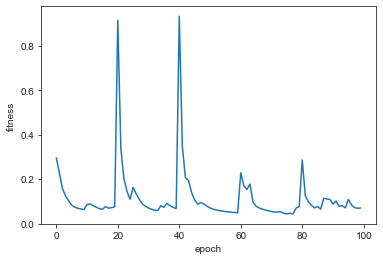

In [351]:
sns.set_style("ticks")
x = list(range(0,len(LossArr)))
fig = sns.lineplot(x,LossArr)
plt.xlabel("epoch")
plt.ylabel("fitness")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./BestFit', dpi = 400)

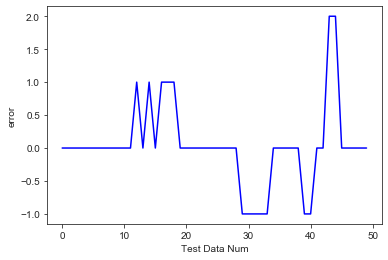

In [348]:
error = y_pred - test_y
x = list(range(0,len(error)))
fig = sns.lineplot(x,error,color="b")
plt.xlabel("Test Data Num")
plt.ylabel("error")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./Error_Num', dpi = 400)



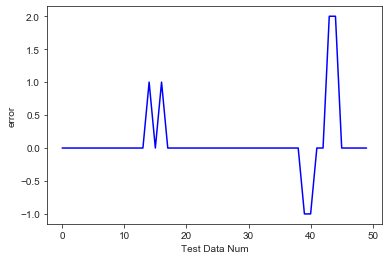

In [352]:
error = result - test_y
x = list(range(0,len(error)))
fig = sns.lineplot(x,error,color="b")
plt.xlabel("Test Data Num")
plt.ylabel("error")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./result', dpi = 400)



In [349]:
len(bestloss),len(bestfit)

(0, 5)

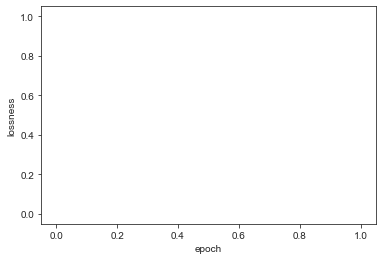

In [350]:
x = list(range(0,len(bestloss)))
fig = sns.lineplot(x,bestloss,color="r")
plt.xlabel("epoch")
plt.ylabel("lossness")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./BestLoss', dpi = 400)

In [ ]:
#sns主题风格  darkgrid  whitegrid  dark  white  ticks
sns.set_style("ticks")  #设置主题风格
sns.color_palette("hls",8)  #设置颜色空间种类（几种可用颜色）
data=np.random.normal(size=(20,8)) + np.arange(8) /2
sns.boxplot(data = data,palette = sns.color_palette("hls",8))

# 描述两个变量的关系 最好用散点图

In [ ]:
import pandas as pd
mean,cov = [0,1],[(1,.5),(.5,1)]
data = np.random.multivariate_normal(mean,cov,200)
df = pd.DataFrame(data,columns=["x","y"])
#绘制散点图
sns.jointplot(x="x",y="y",data = df,color="r")  #如果点很多，用颜色深度表示数量 kind="hex" ,可以单独传x y

# 移植STM32准备

In [ ]:
Testx = X / X.max().max()
Testx = np.array(Testx)

In [ ]:
aa = []
aa.append(list(Testx[0]))
aa

In [ ]:
pre_sig=model.predict(aa)
pre_sig

In [ ]:
index = np.argmax(pre_sig,axis=None)
index

In [ ]:
Y

# 模型保存

In [ ]:
model.save('Env.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(load_model)
tflite_model = converter.convert()
open("level_check.tflite", "wb").write(tflite_model)

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras import Sequential
import tensorflow.keras as keras
import numpy as np

In [ ]:


# #建立一个测试模型
model = Sequential([
    Dense(4, input_shape=(5,), name='dense_xiaoming',
          kernel_initializer='zeros',  # 全部初始化为0
          bias_initializer='ones'),  # 全部初始化为1
])



In [ ]:
x = np.ones(shape=(8, 5))  # 创建测试数据
y = model(x)
layer = model.get_layer('dense_xiaoming')  # 通过层的名字得到层
(k, b) = layer.get_weights()  # 查看层的初始化权重值和偏置项
print(k)
print(b)

In [ ]:
layer